# Gradient Descent

Exploring empirical behavior of gradient descent during training. Some questions of interest are:


- how big is a step?

    - per layer, per neuron, entire network?
    - how does it change over the course of training?
- what do good starting initializations look like?
-  where does the network end up
?
	- ie, how much do the parameters actually shift?

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Generator

import pandas as pd

In [2]:
# run exploration notebook to get classes -- in the future, might be worth a more elegant solution, like putting custom classes into a distinct .py file

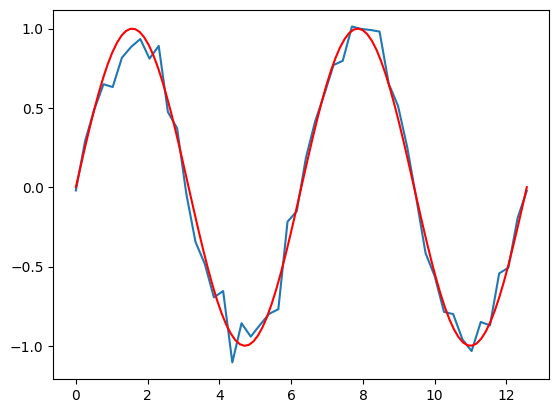

Epoch: 1


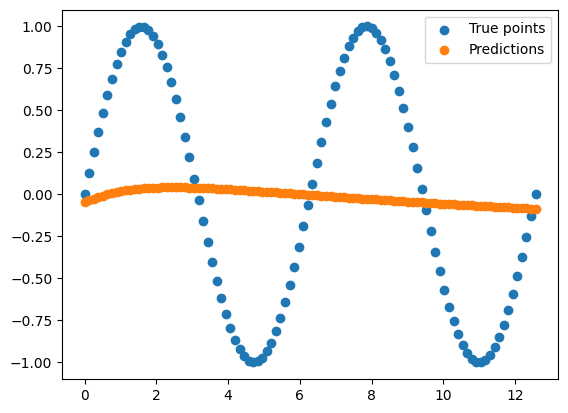

Avg loss: 0.481275 

Epoch: 2


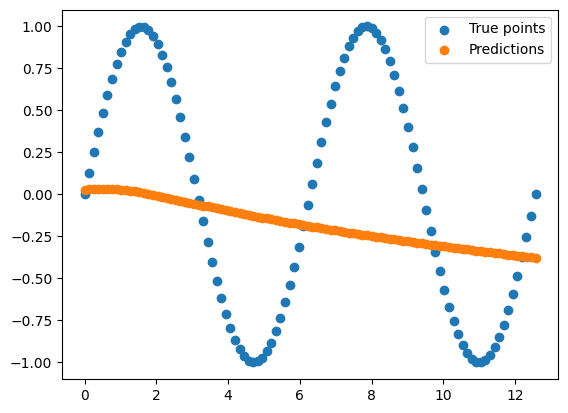

Avg loss: 0.471682 

Epoch: 3


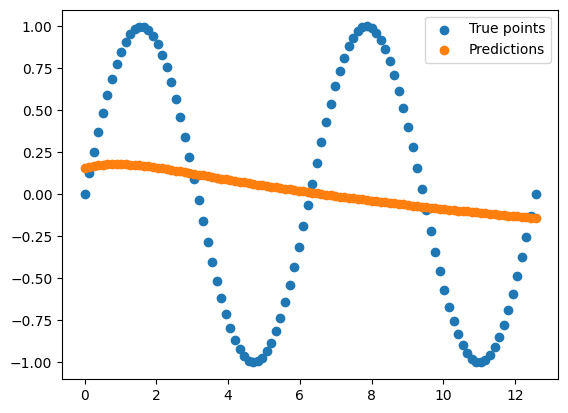

Avg loss: 0.450205 

Epoch: 4


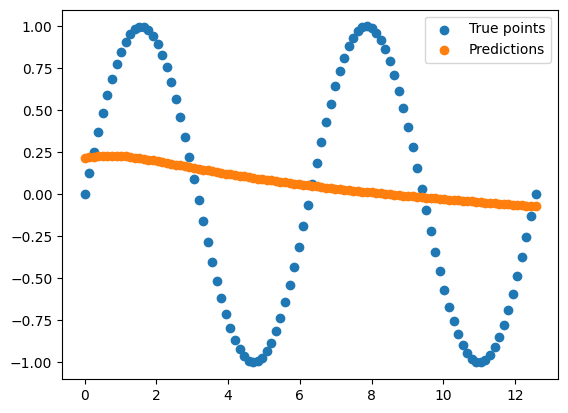

Avg loss: 0.455657 

Epoch: 5


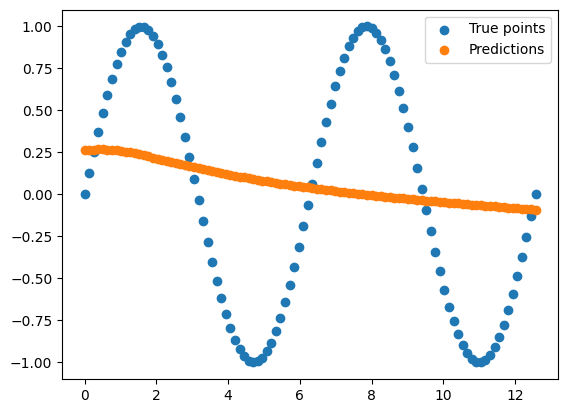

Avg loss: 0.448381 

Epoch: 6


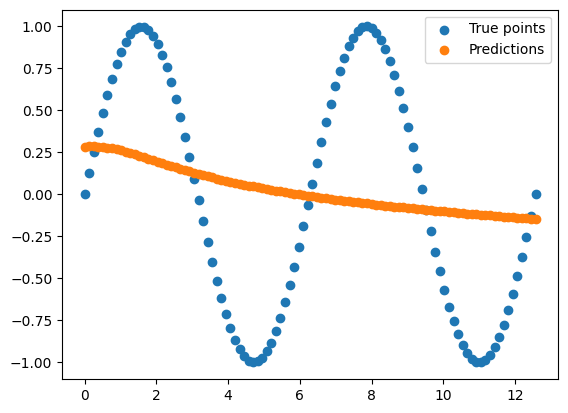

Avg loss: 0.437744 

Epoch: 7


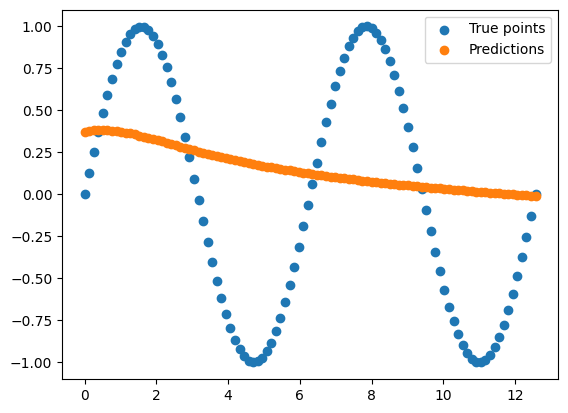

Avg loss: 0.464392 

Epoch: 8


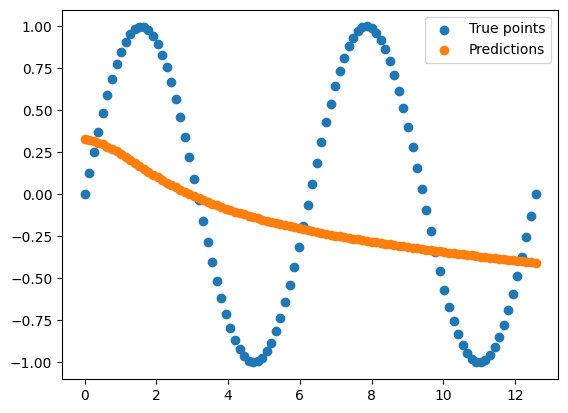

Avg loss: 0.440935 

Epoch: 9


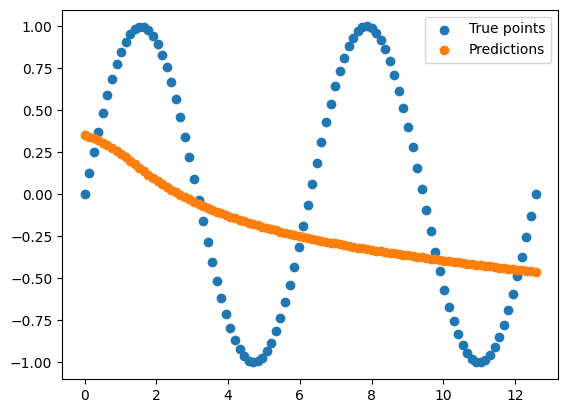

Avg loss: 0.451155 

Epoch: 10


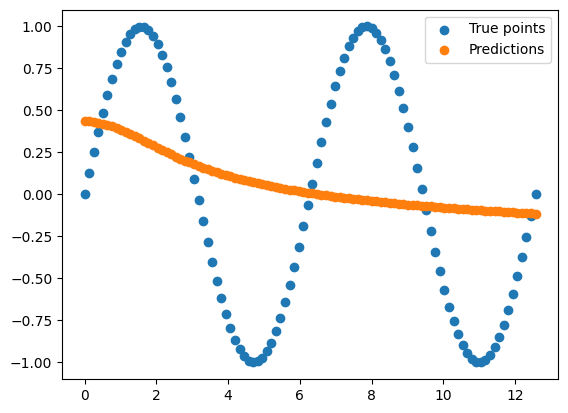

Avg loss: 0.431022 

Epoch: 11


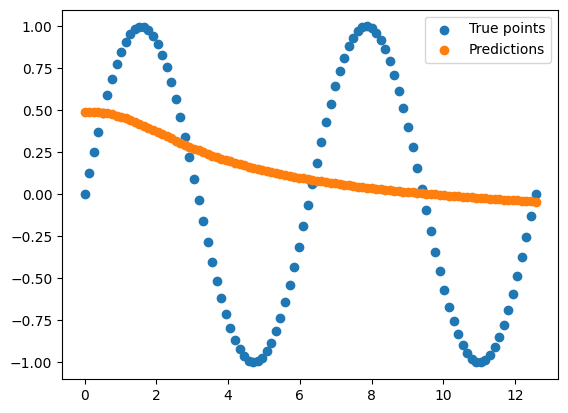

Avg loss: 0.448449 

Epoch: 12


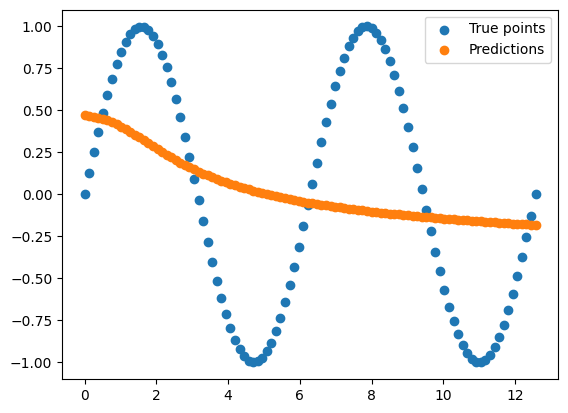

Avg loss: 0.419912 

Epoch: 13


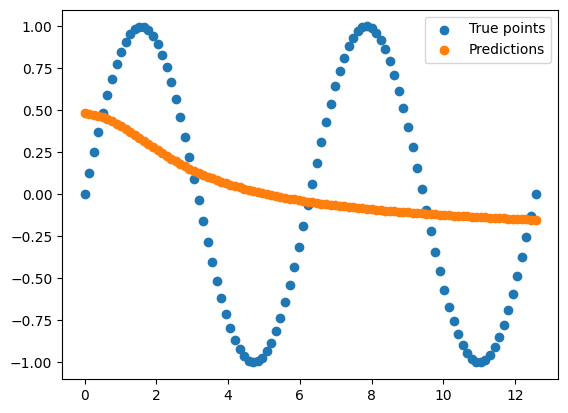

Avg loss: 0.421381 

Epoch: 14


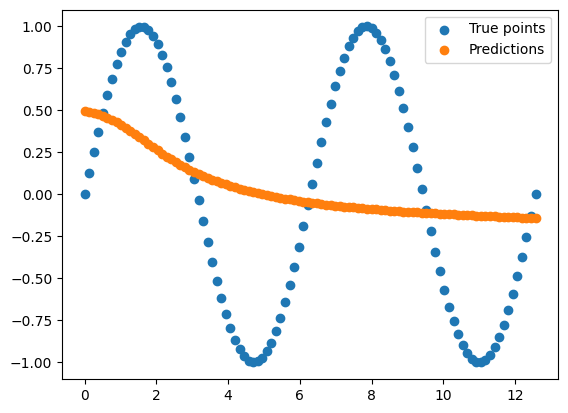

Avg loss: 0.421066 

Epoch: 15


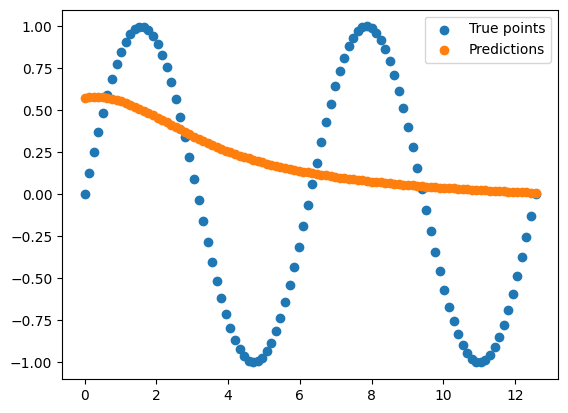

Avg loss: 0.463930 

Epoch: 40


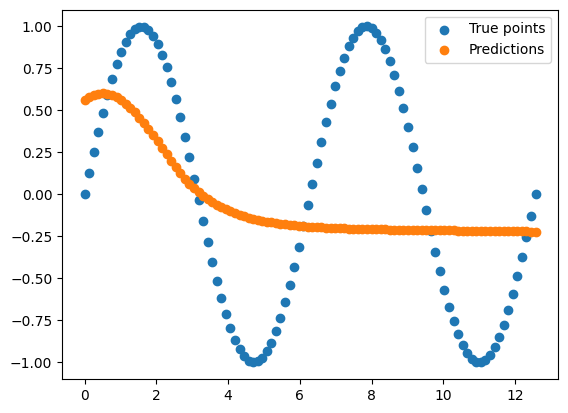

Avg loss: 0.394415 

Epoch: 80


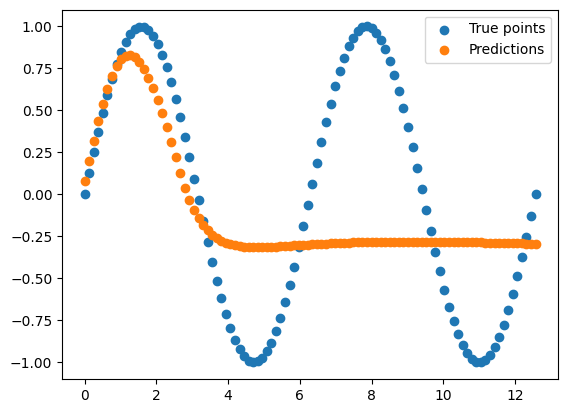

Avg loss: 0.350841 

Epoch: 120


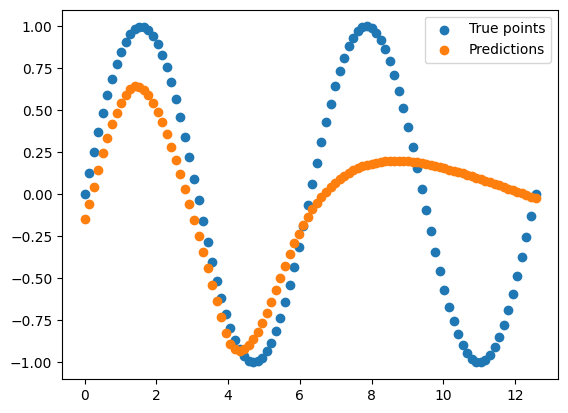

Avg loss: 0.269533 

Epoch: 160


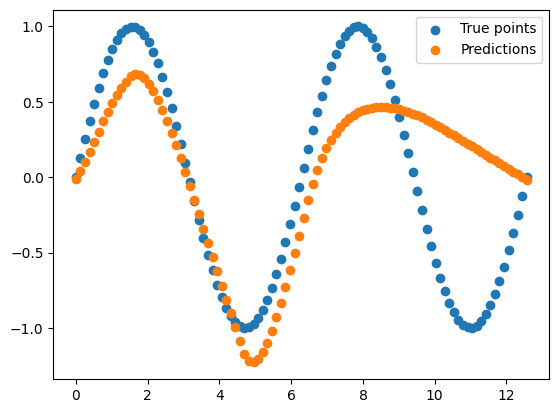

Avg loss: 0.275796 

Epoch: 200


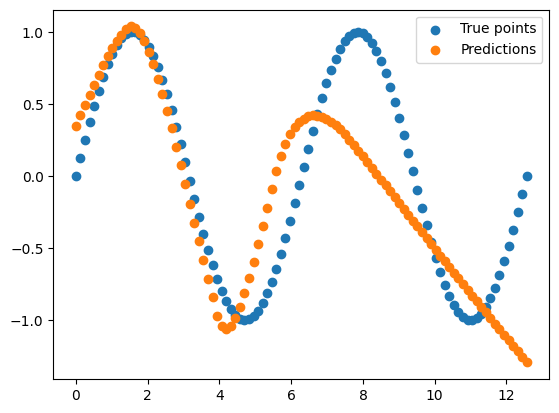

Avg loss: 0.196679 

Done!
Epoch: 1


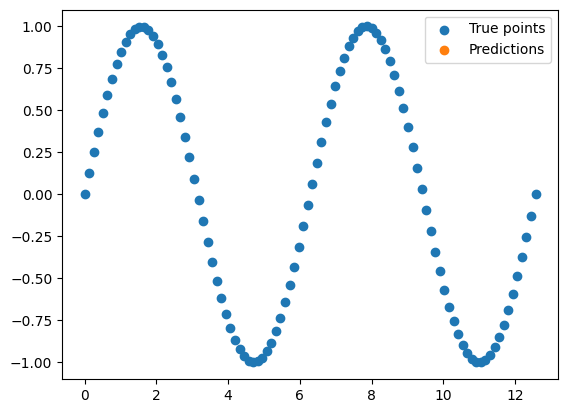

Avg loss:      nan 

Epoch: 2


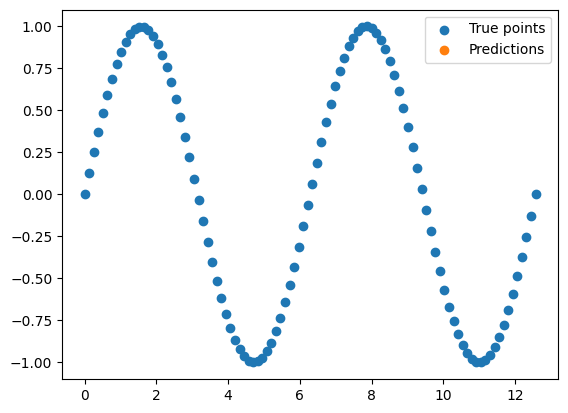

Avg loss:      nan 

Epoch: 3


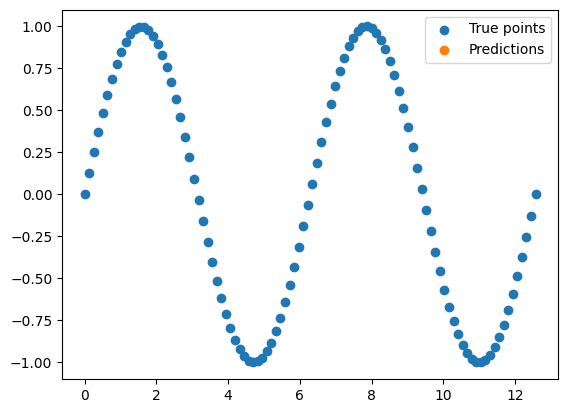

Avg loss:      nan 

Epoch: 4


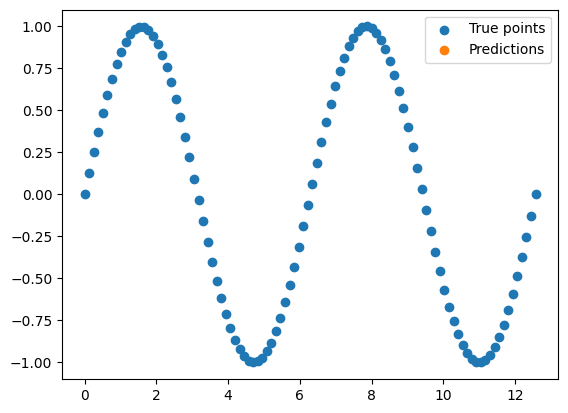

Avg loss:      nan 

Epoch: 5


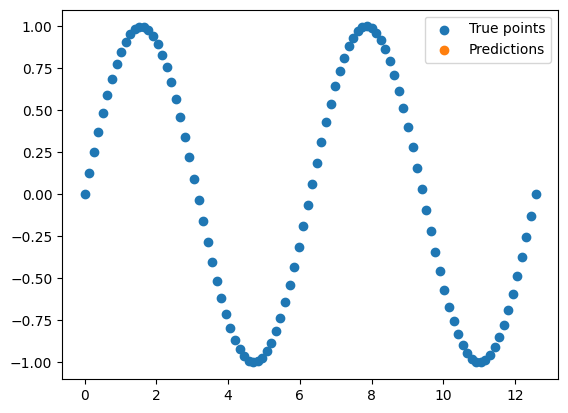

Avg loss:      nan 

Epoch: 6


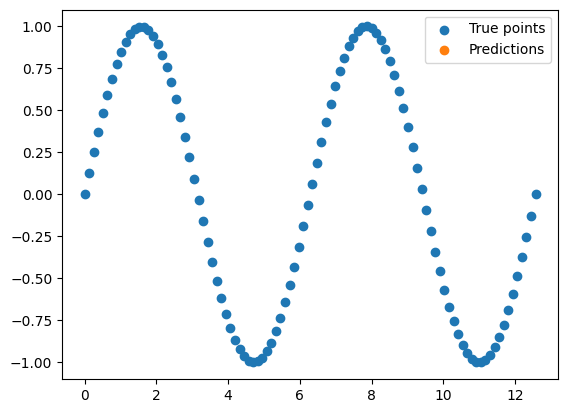

Avg loss:      nan 

Epoch: 7


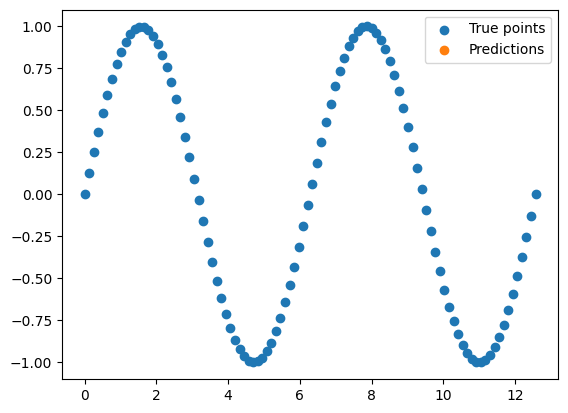

Avg loss:      nan 

Epoch: 8


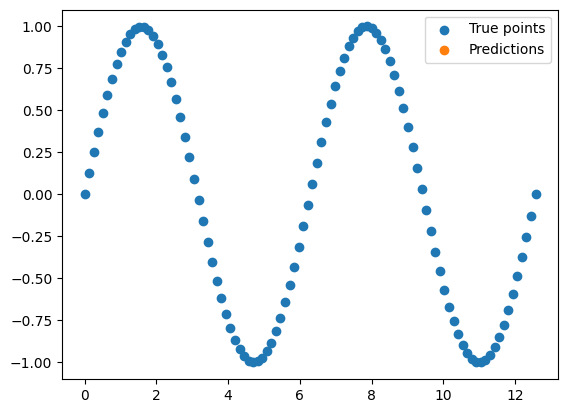

Avg loss:      nan 

Epoch: 9


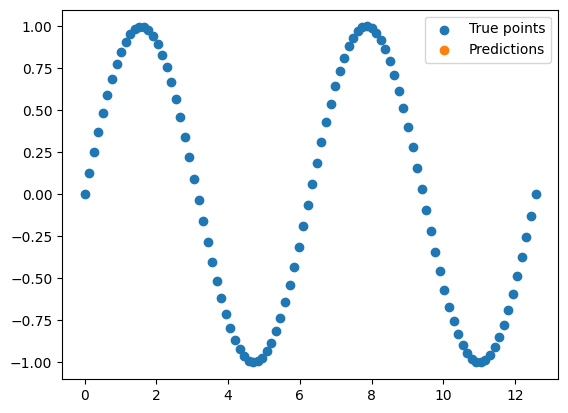

Avg loss:      nan 

Epoch: 10


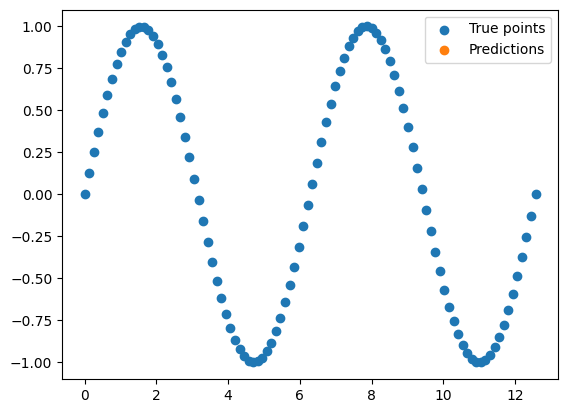

Avg loss:      nan 

Epoch: 11


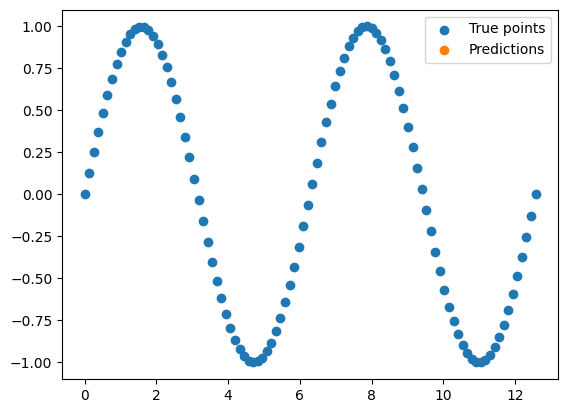

Avg loss:      nan 

Epoch: 12


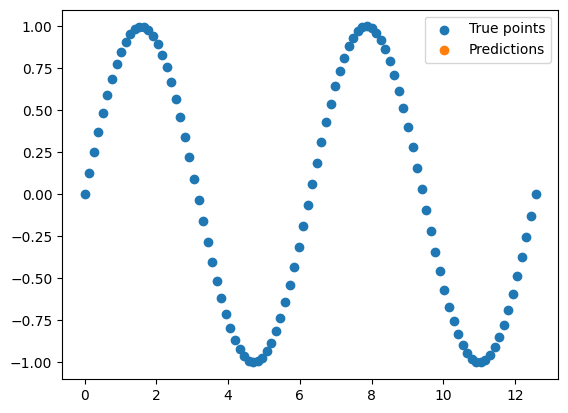

Avg loss:      nan 

Epoch: 13


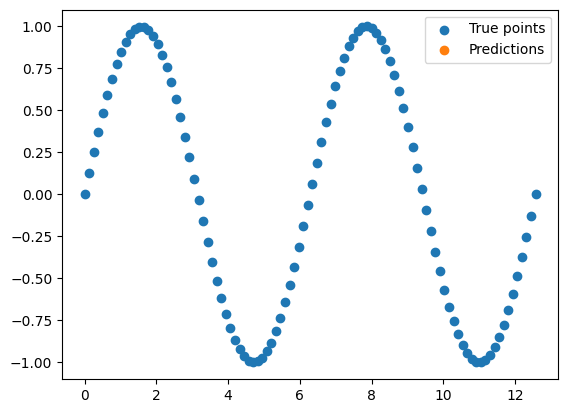

Avg loss:      nan 

Epoch: 14


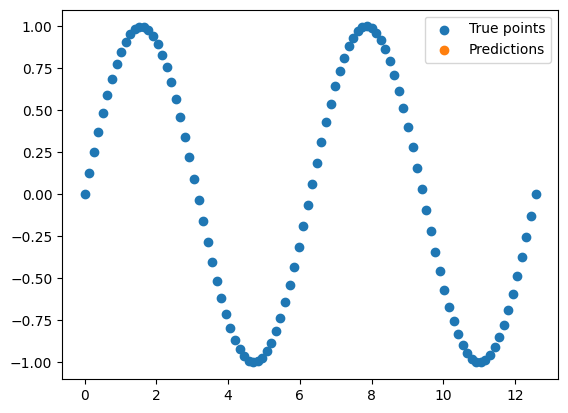

Avg loss:      nan 

Epoch: 15


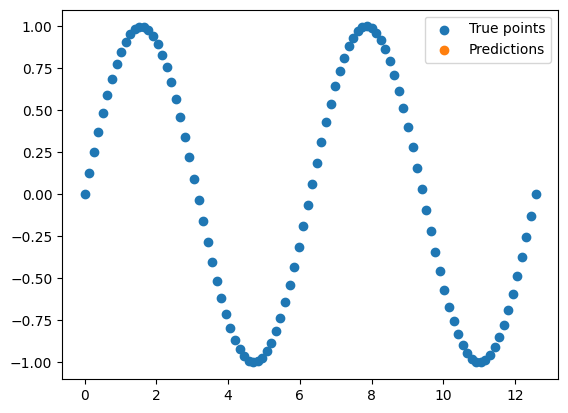

Avg loss:      nan 

Epoch: 40


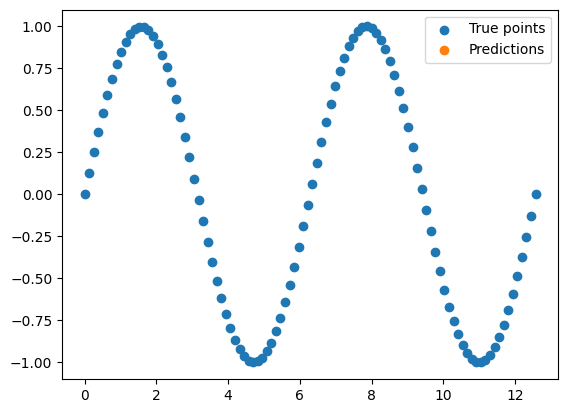

Avg loss:      nan 

Epoch: 80


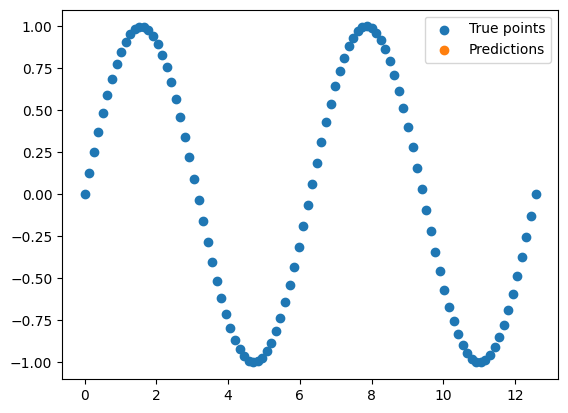

Avg loss:      nan 

Epoch: 120


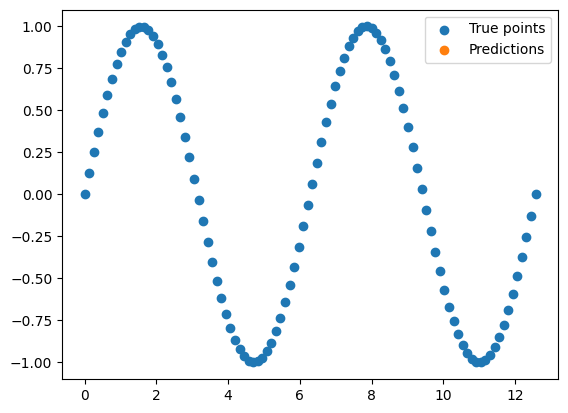

Avg loss:      nan 

Epoch: 160


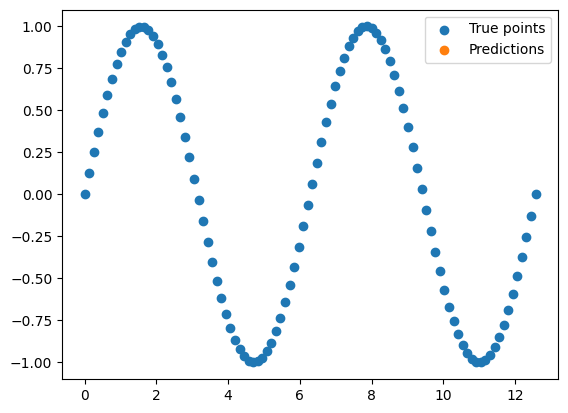

Avg loss:      nan 

Epoch: 200


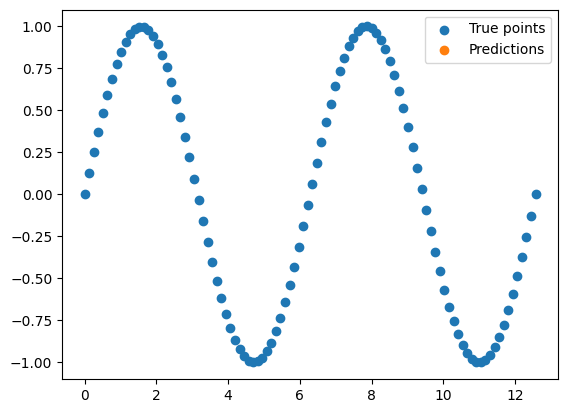

Avg loss:      nan 

Done!
Norm of untrained model: 4.615544582762766
Norm of trained standard model: 6.289472965801254
Norm of trained preconditioned model: nan
Residual from preconditioning: nan
Residual between trained models: nan


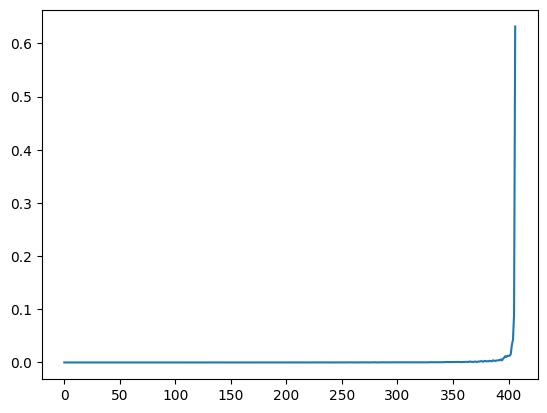

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 40
Epoch: 80
Epoch: 120
Epoch: 160
Epoch: 200
Done!


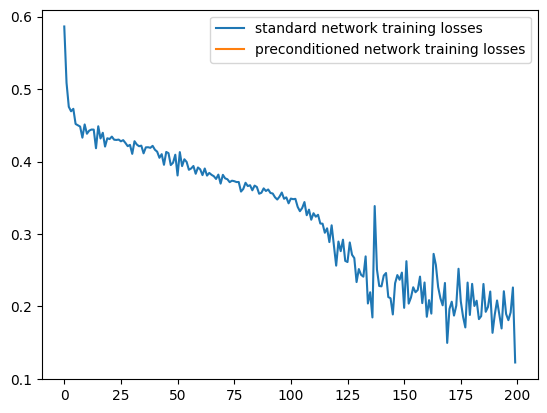

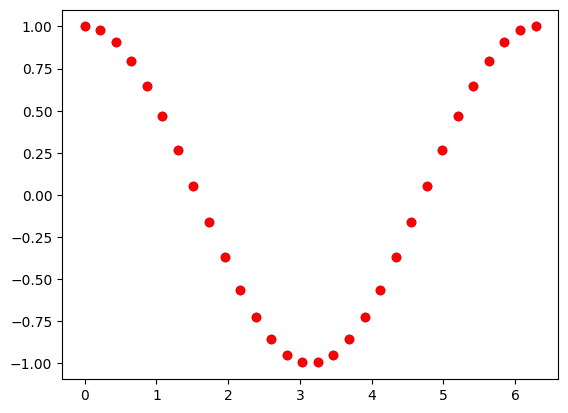

Epoch: 1


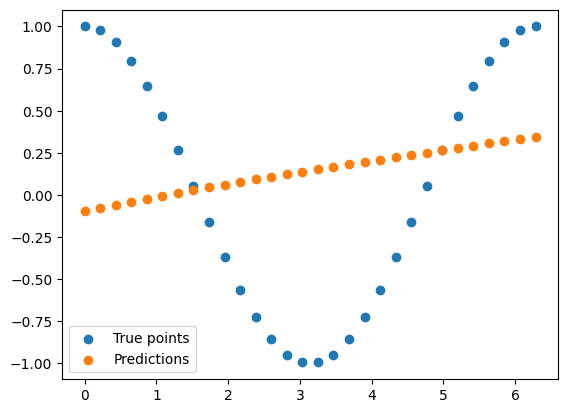

Avg loss: 0.552938 

Epoch: 2


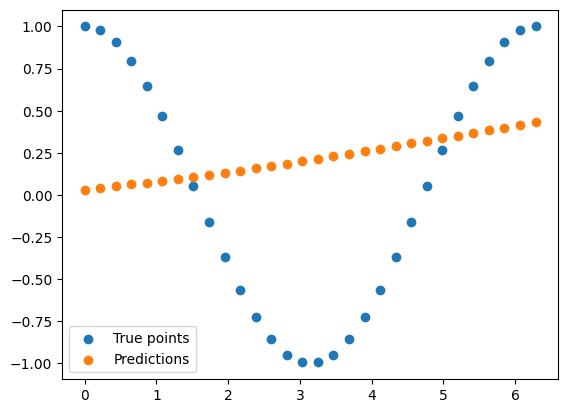

Avg loss: 0.552544 

Epoch: 3


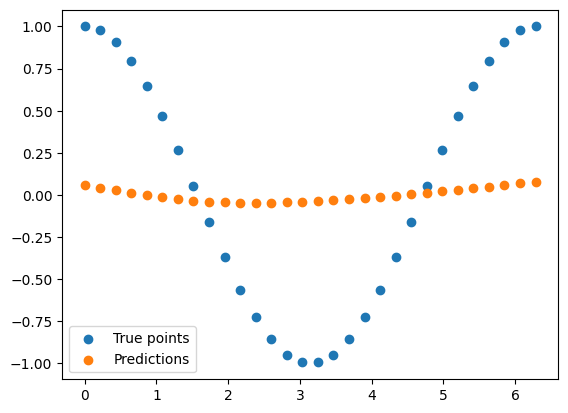

Avg loss: 0.470792 

Epoch: 4


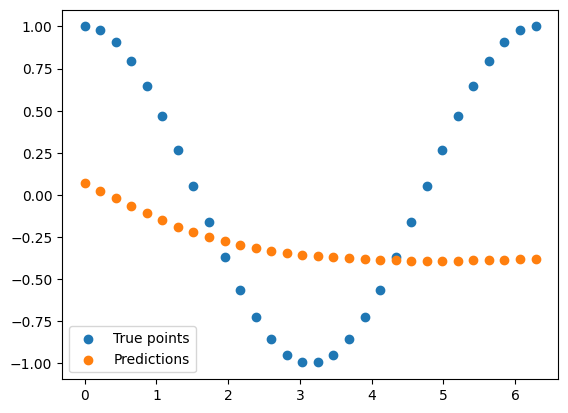

Avg loss: 0.544694 

Epoch: 5


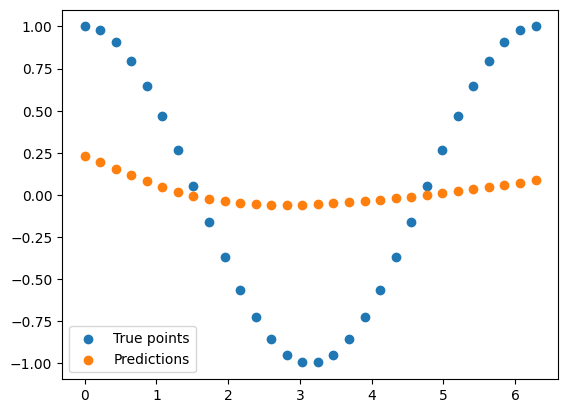

Avg loss: 0.426138 

Epoch: 6


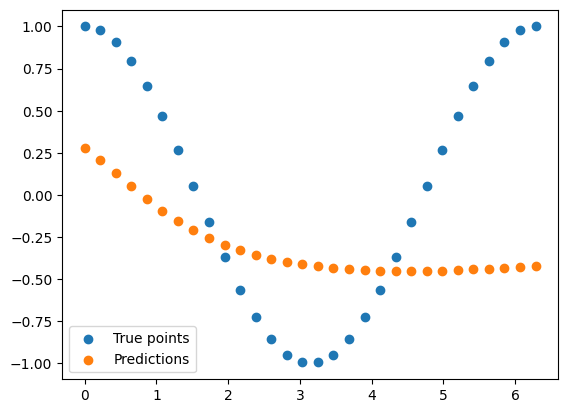

Avg loss: 0.513366 

Epoch: 7


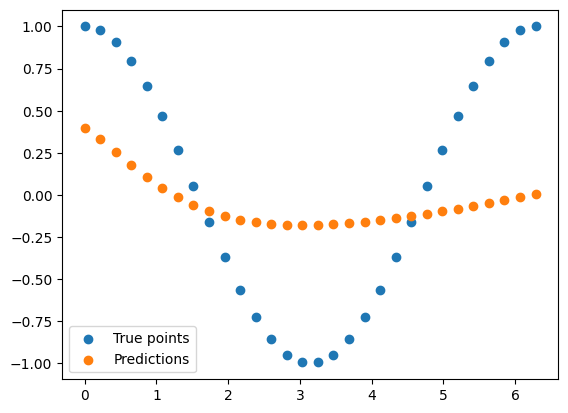

Avg loss: 0.375912 

Epoch: 8


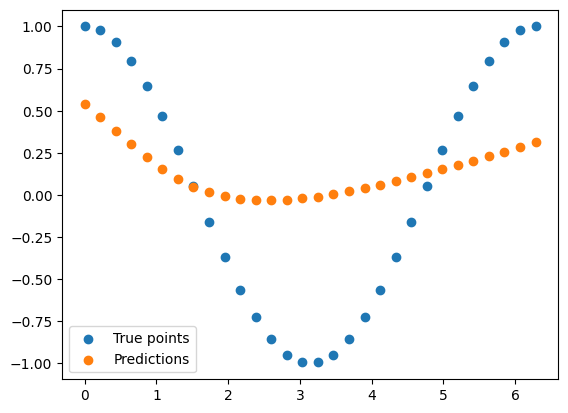

Avg loss: 0.353457 

Epoch: 9


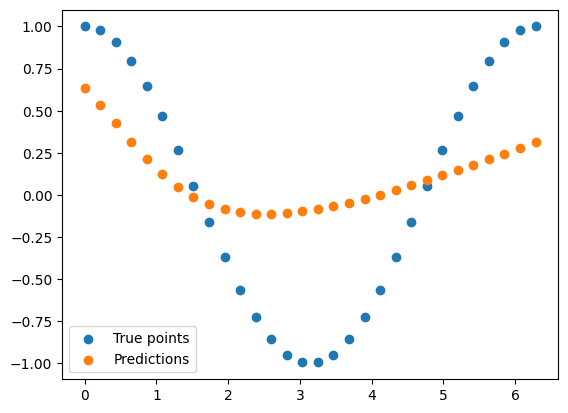

Avg loss: 0.309203 

Epoch: 10


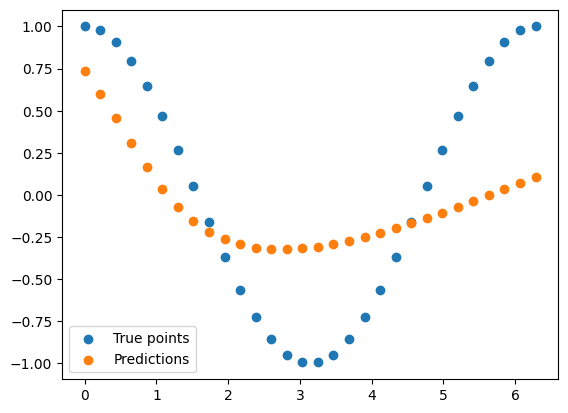

Avg loss: 0.273253 

Epoch: 11


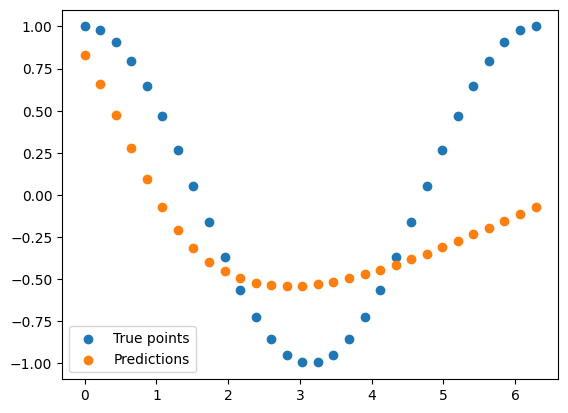

Avg loss: 0.301355 

Epoch: 12


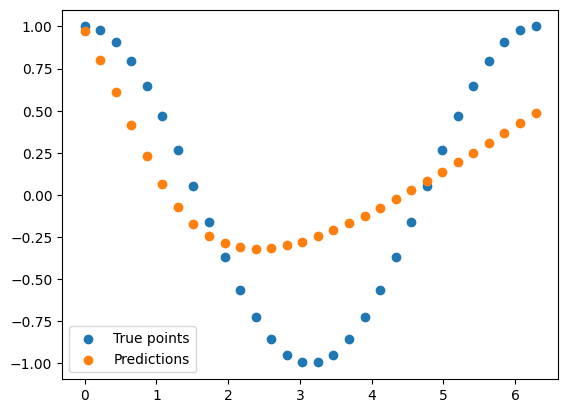

Avg loss: 0.196988 

Epoch: 13


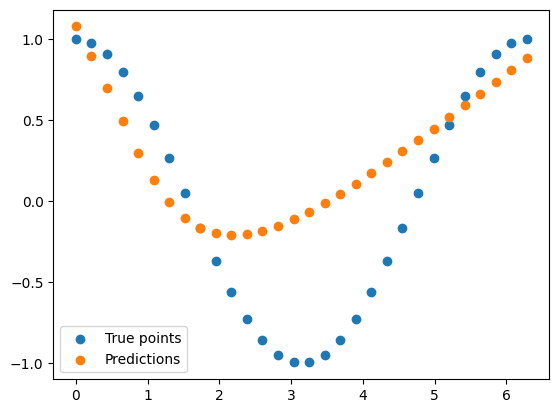

Avg loss: 0.247208 

Epoch: 14


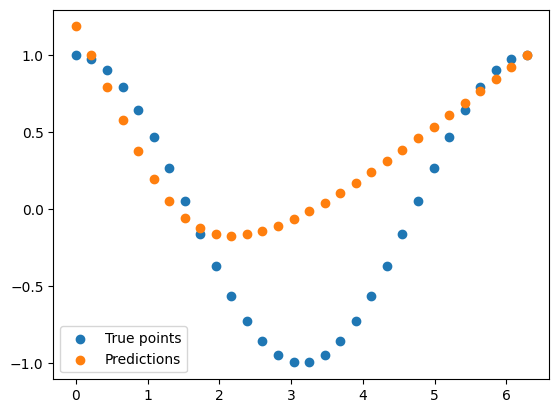

Avg loss: 0.275157 

Epoch: 15


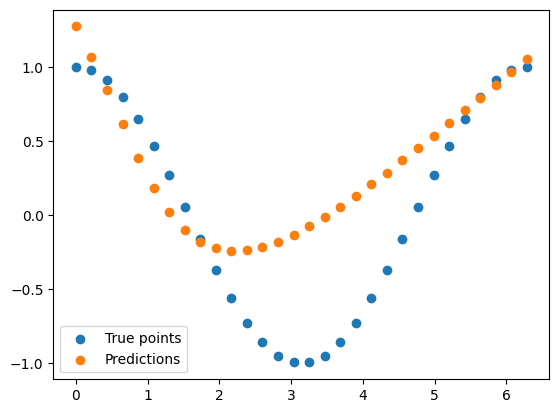

Avg loss: 0.243949 

Epoch: 40


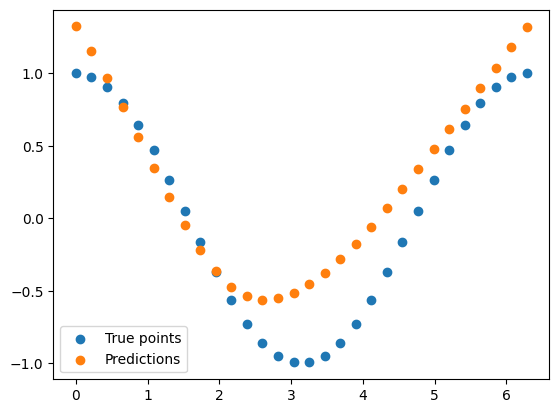

Avg loss: 0.095619 

Epoch: 80


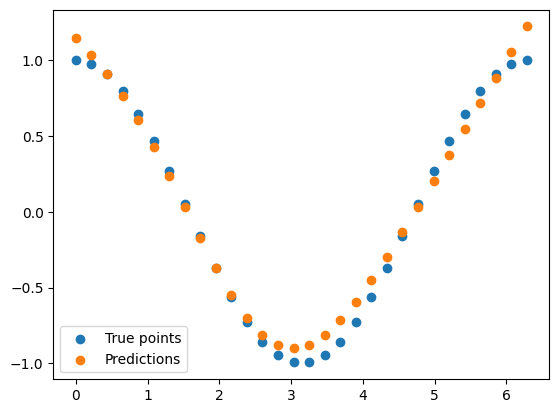

Avg loss: 0.007388 

Epoch: 120


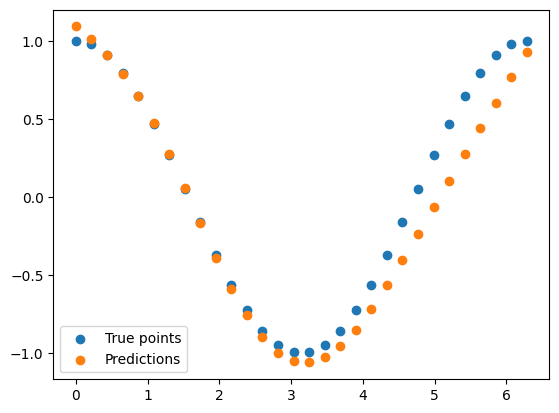

Avg loss: 0.030514 

Epoch: 160


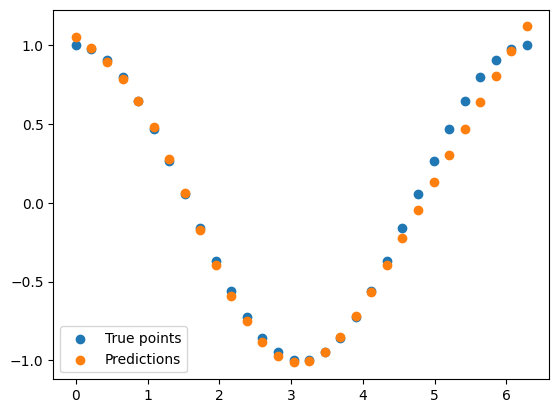

Avg loss: 0.004971 

Epoch: 200


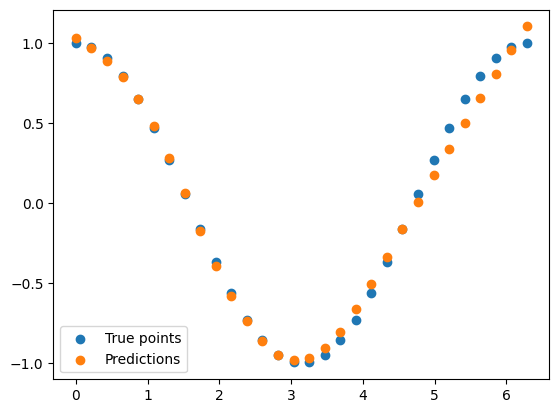

Avg loss: 0.003619 

Done!
Epoch: 1


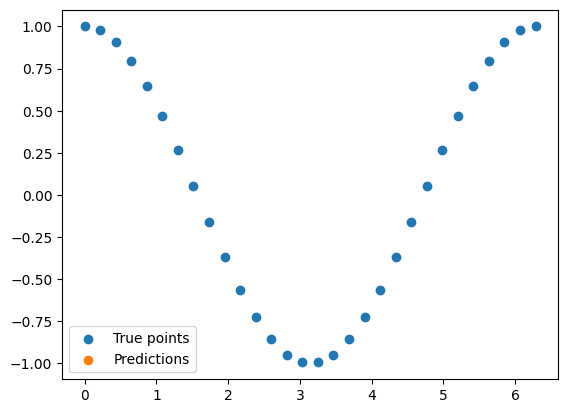

Avg loss:      nan 

Epoch: 2


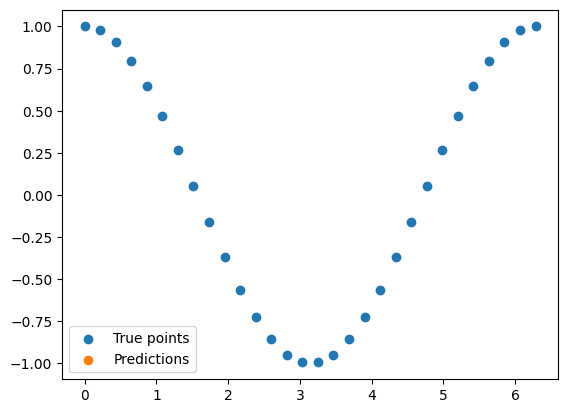

Avg loss:      nan 

Epoch: 3


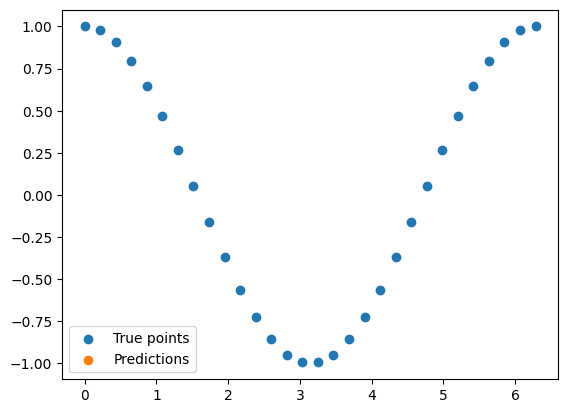

Avg loss:      nan 

Epoch: 4


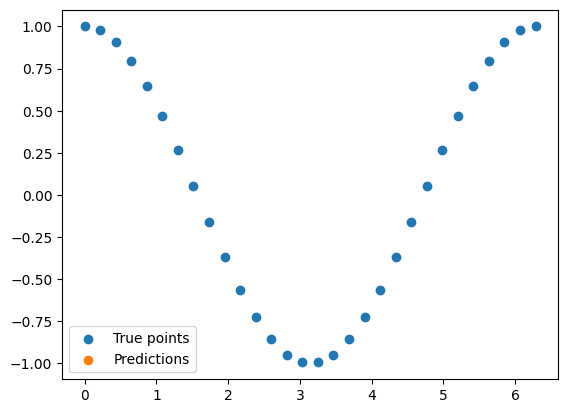

Avg loss:      nan 

Epoch: 5


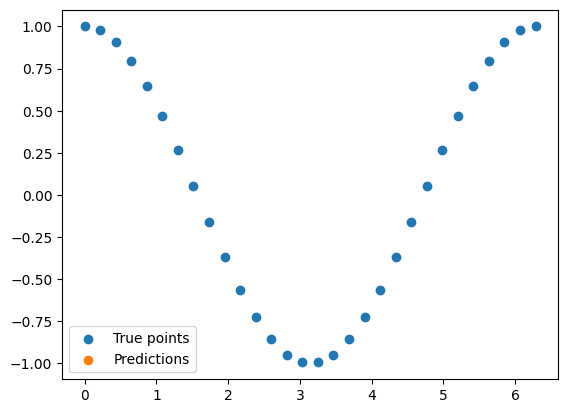

Avg loss:      nan 

Epoch: 6


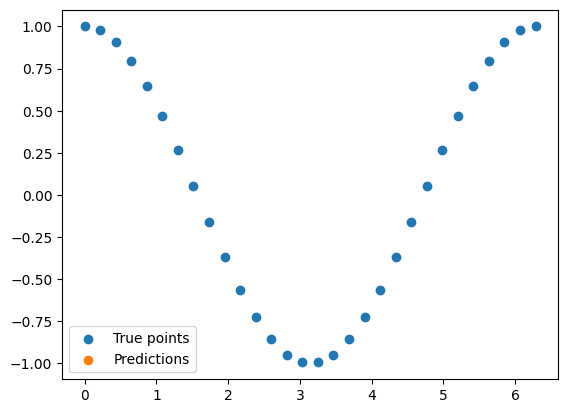

Avg loss:      nan 

Epoch: 7


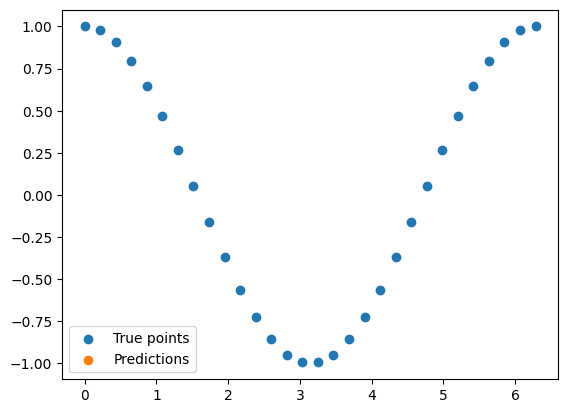

Avg loss:      nan 

Epoch: 8


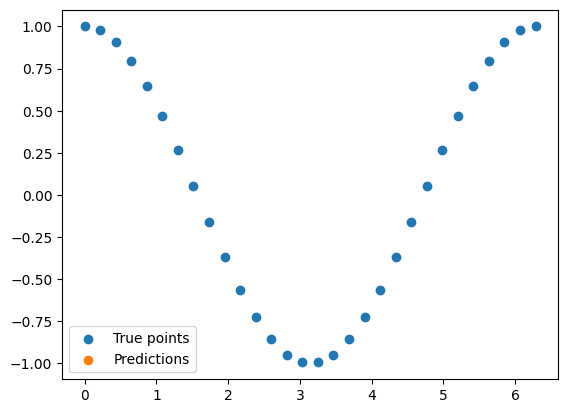

Avg loss:      nan 

Epoch: 9


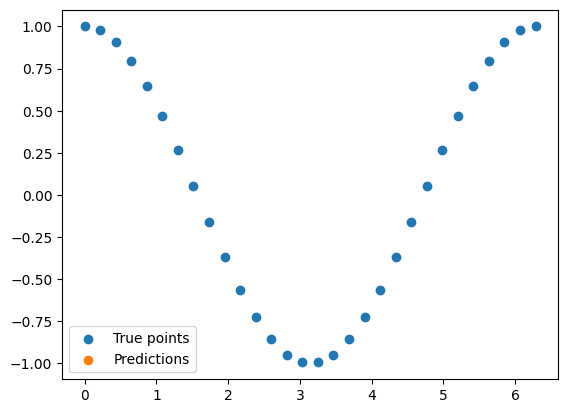

Avg loss:      nan 

Epoch: 10


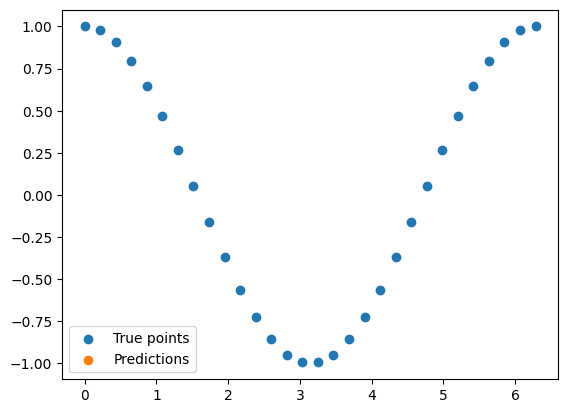

Avg loss:      nan 

Epoch: 11


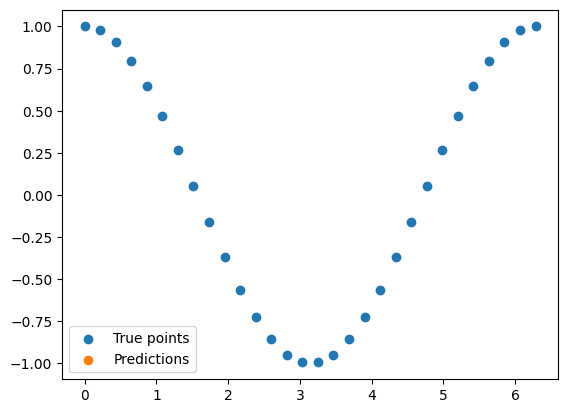

Avg loss:      nan 

Epoch: 12


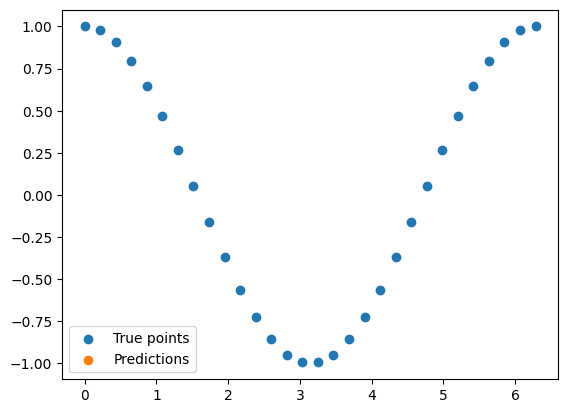

Avg loss:      nan 

Epoch: 13


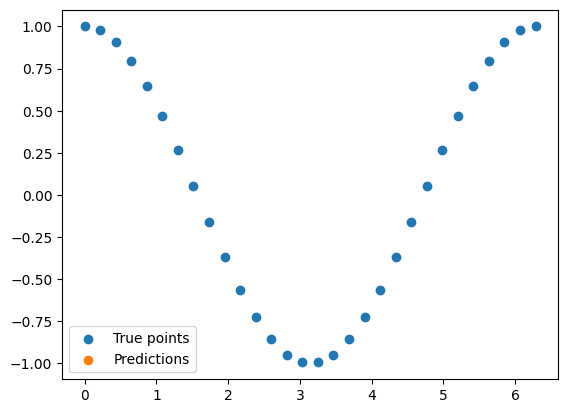

Avg loss:      nan 

Epoch: 14


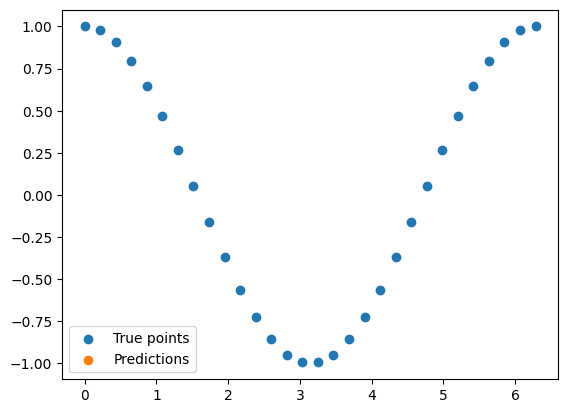

Avg loss:      nan 

Epoch: 15


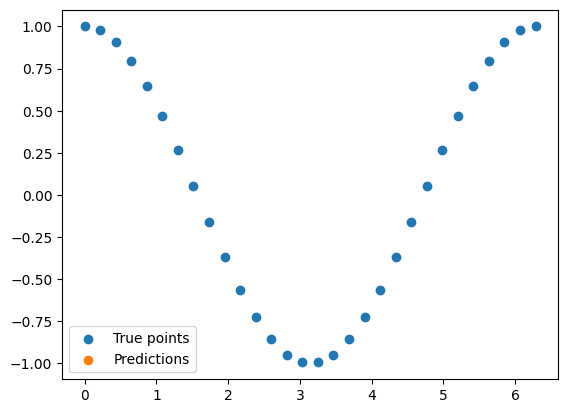

Avg loss:      nan 

Epoch: 40


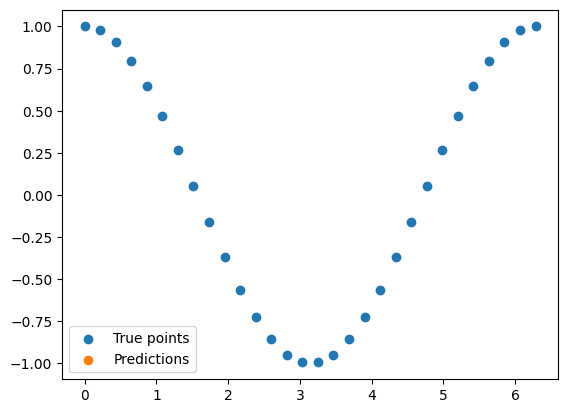

Avg loss:      nan 

Epoch: 80


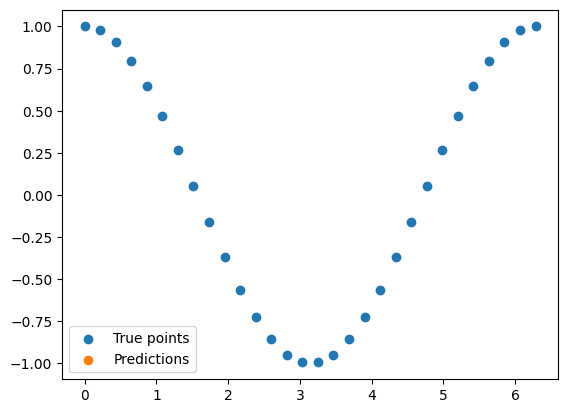

Avg loss:      nan 

Epoch: 120


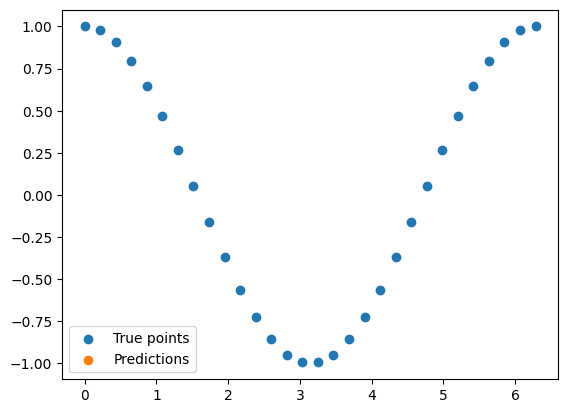

Avg loss:      nan 

Epoch: 160


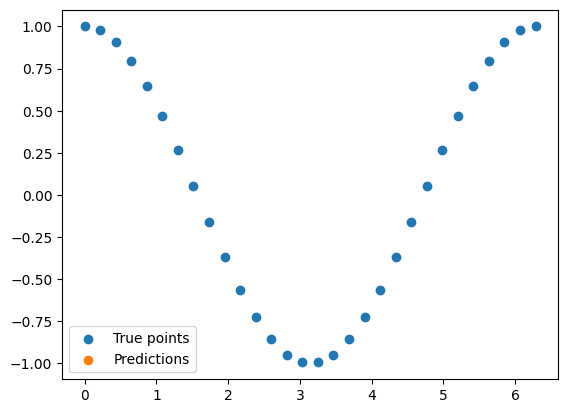

Avg loss:      nan 

Epoch: 200


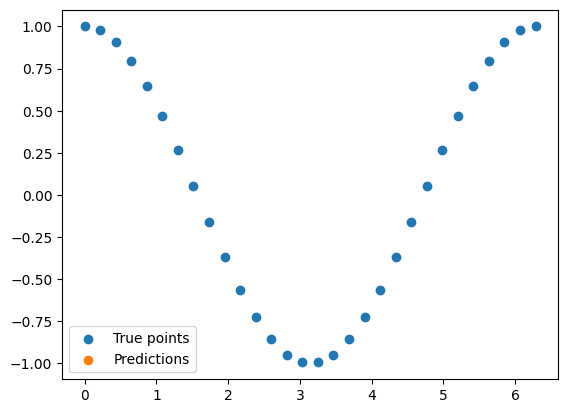

Avg loss:      nan 

Done!


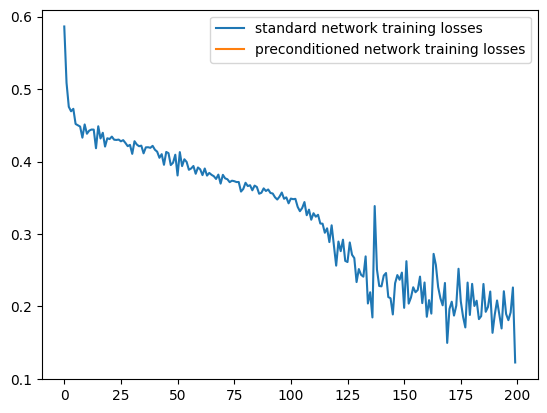

tensor([0.6981])
tensor([2.7925])
tensor([5.5851])
tensor([0.])
tensor([2.0944])
tensor([1.3963])
tensor([6.2832])
tensor([3.4907])
tensor([4.8869])
tensor([4.1888])

tensor([0.6981])
tensor([2.7925])
tensor([5.5851])
tensor([0.])
tensor([2.0944])
tensor([1.3963])
tensor([6.2832])
tensor([3.4907])
tensor([4.8869])
tensor([4.1888])


In [3]:
%run exploration.ipynb

In [4]:
def train_loop_grad_capture(dataloader, model, loss_fn, optimizer, jitter=0):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    gradients = {}
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X + torch.normal(0, jitter, X.shape))
        loss = loss_fn(pred, y)
        if torch.isnan(loss).item():
            nan_losses += 1
        # Backpropagation
        loss.backward()

        for name, param in model.named_parameters():
            if name not in gradients:
                gradients[name] = []
            
            if param.grad is not None:
                gradients[name].append(param.grad.clone())
            else:
                print(name)
        
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
    
    return total_loss / batches, gradients

In [5]:
learning_rate = 1e-2
epochs = 800
train_noise = 0.1

In [6]:
base_gen = Generator()
base_gen.seed()

normal_model = TinyModel()
precond_model = copy.deepcopy(normal_model)

train_dataset = FunctionDataset(torch.sin, 100, stop=2*math.pi, noise=train_noise)
test_dataset = FunctionDataset(torch.sin, 100, stop=2*math.pi, rand_pts=False)


train_gen = Generator().set_state(base_gen.get_state())
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, generator=train_gen)

test_gen = Generator().set_state(base_gen.get_state())
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, generator=test_gen)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(normal_model.parameters(), lr=learning_rate)

Epoch: 1


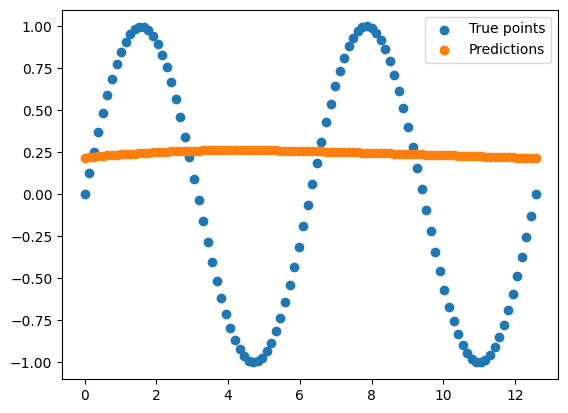

Avg loss: 0.554088 

Epoch: 2


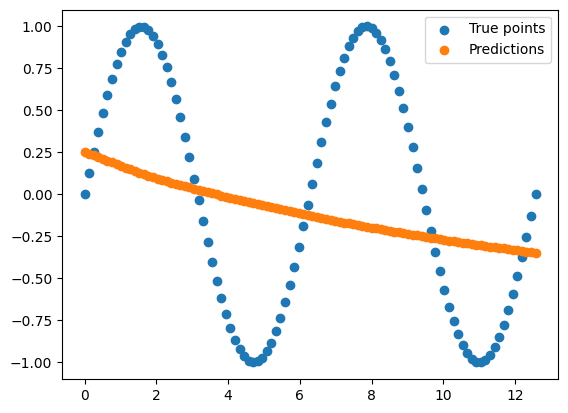

Avg loss: 0.442590 

Epoch: 3


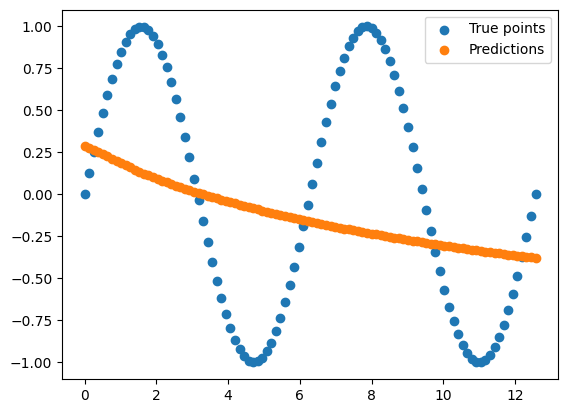

Avg loss: 0.443238 

Epoch: 4


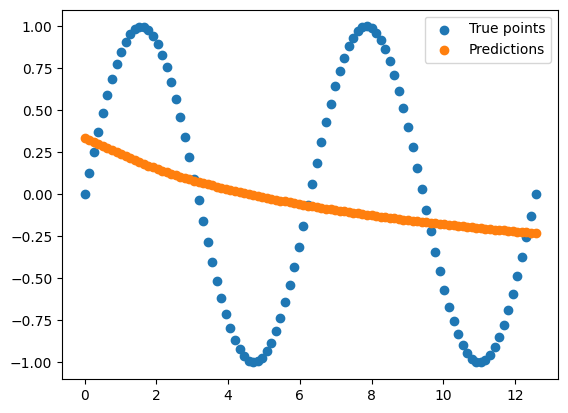

Avg loss: 0.434088 

Epoch: 5


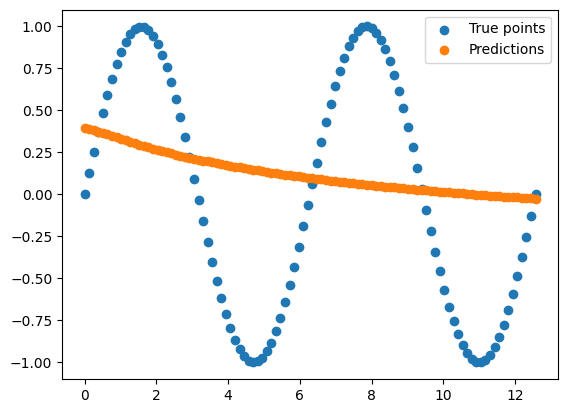

Avg loss: 0.459632 

Epoch: 6


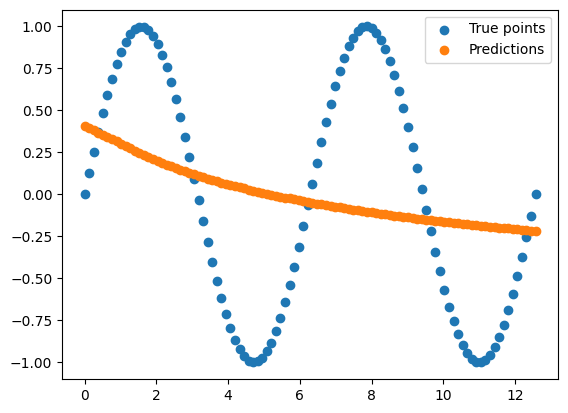

Avg loss: 0.428789 

Epoch: 7


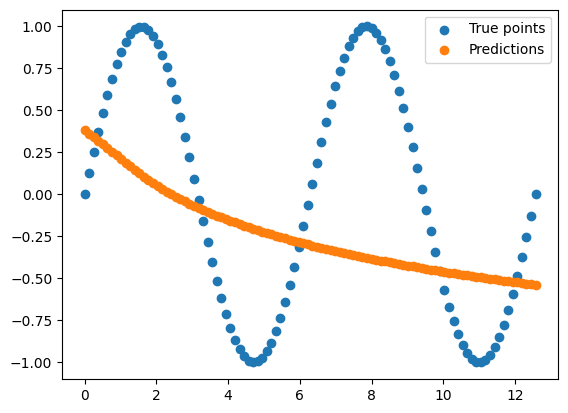

Avg loss: 0.472153 

Epoch: 8


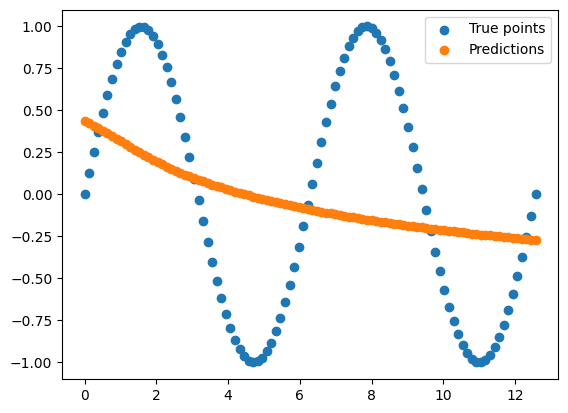

Avg loss: 0.425062 

Epoch: 9


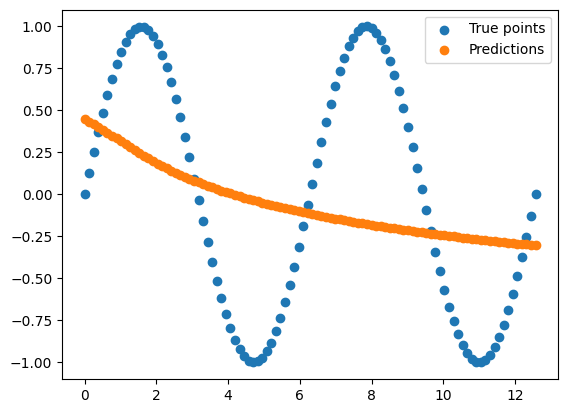

Avg loss: 0.424934 

Epoch: 10


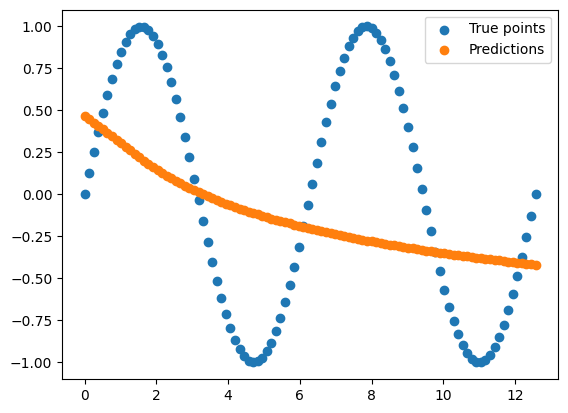

Avg loss: 0.435168 

Epoch: 11


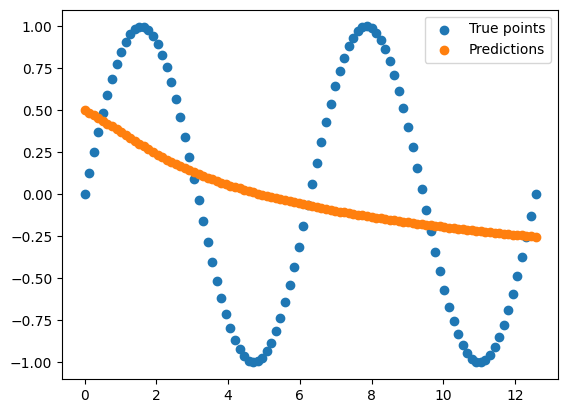

Avg loss: 0.421312 

Epoch: 12


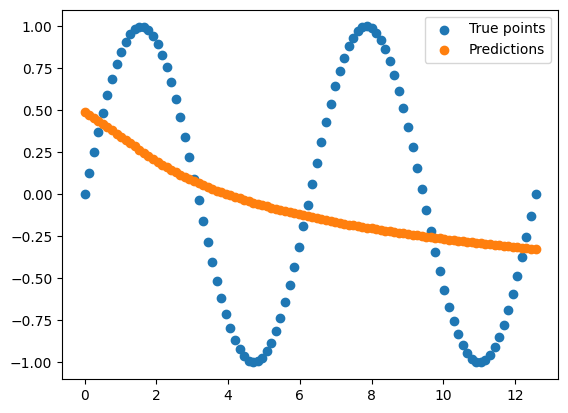

Avg loss: 0.423187 

Epoch: 13


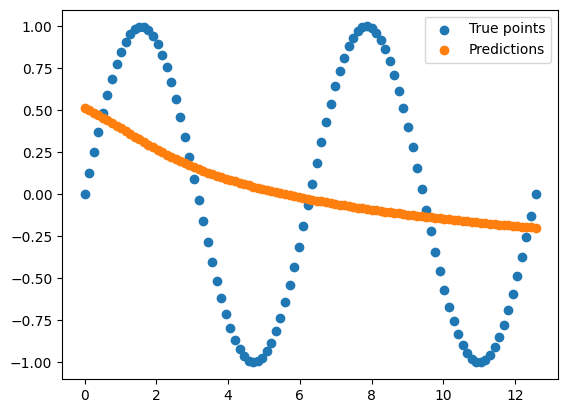

Avg loss: 0.423538 

Epoch: 14


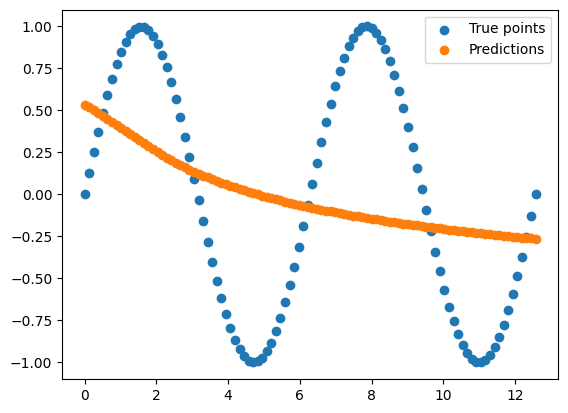

Avg loss: 0.419047 

Epoch: 15


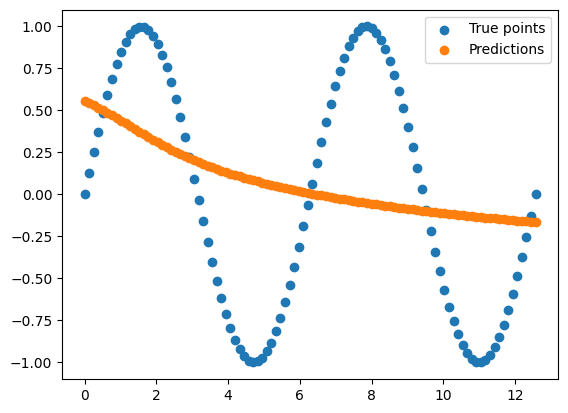

Avg loss: 0.426476 

Epoch: 160


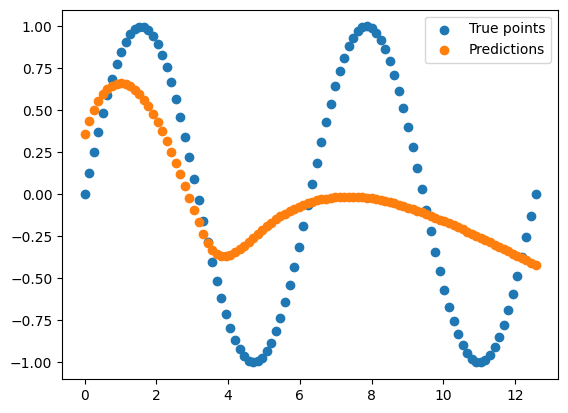

Avg loss: 0.285539 

Epoch: 320


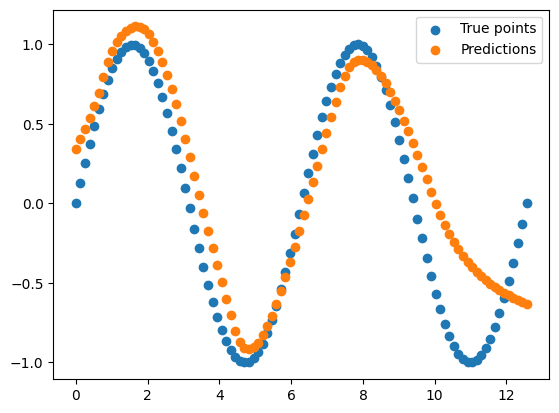

Avg loss: 0.088861 

Epoch: 480


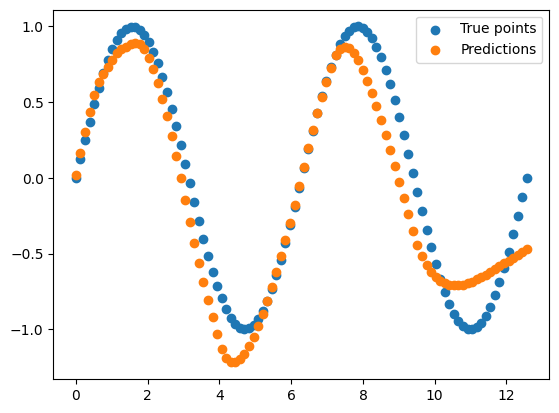

Avg loss: 0.048143 

Epoch: 640


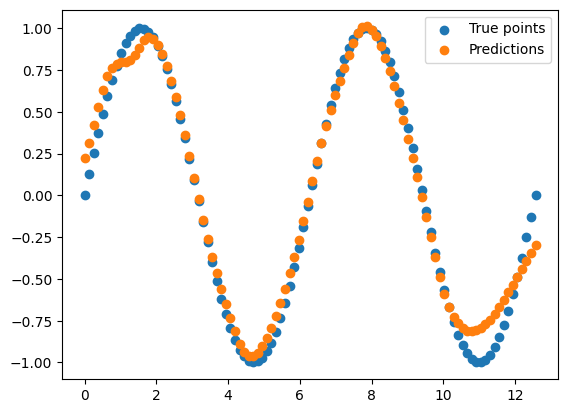

Avg loss: 0.008889 

Epoch: 800


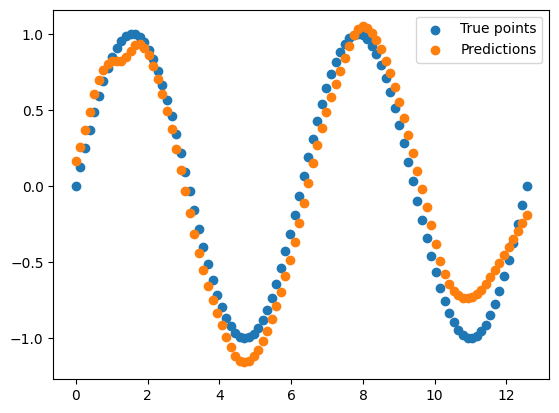

Avg loss: 0.022546 



In [7]:
standard_train_losses = []
grads_per_epoch = []

for t in range(epochs):
    
    avg_loss, gradients = train_loop_grad_capture(train_dataloader, normal_model, loss_function, optimizer)
    standard_train_losses.append(avg_loss)
    grads_per_epoch.append(gradients)
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, normal_model, loss_function)

In [8]:
keys = [x for x in grads_per_epoch[1].keys()]
print(keys)

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']


In [9]:
def make_grad_lists(grads_per_epoch):
    keys = [x for x in grads_per_epoch[0].keys()]
    combined_grads = {}
    for key in keys:
        combined_grads[key] = []
        
    for i in range(len(grads_per_epoch)):
        for parameter in keys:
            # This concatenation is wrong, they need to be combined along a new, third axis
            # then, later one, we can take the frobenius norm of each set of weights along that third axis
            # i think
            #grads_per_epoch[i][parameter] = torch.linalg.norm(grads_per_epoch[i][parameter])
            combined_grads[parameter].extend(grads_per_epoch[i][parameter])
    return combined_grads


def normed_grad_lists(grad_lists):
    normed_grads = {}
    keys = [x for x in grad_lists.keys()]
    for key in keys:
        normed_grads[key] = []
    for param in keys:
        for gradient in grad_lists[param]:
            normed_grads[param].append(torch.linalg.norm(gradient).item())
    return normed_grads

In [10]:
grad_lists = make_grad_lists(grads_per_epoch)
grad_norm_lists = normed_grad_lists(grad_lists)

In [11]:
keys = [x for x in grad_norm_lists.keys()]
print(keys)
print(len(grad_norm_lists['layers.0.weight']))

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']
40000


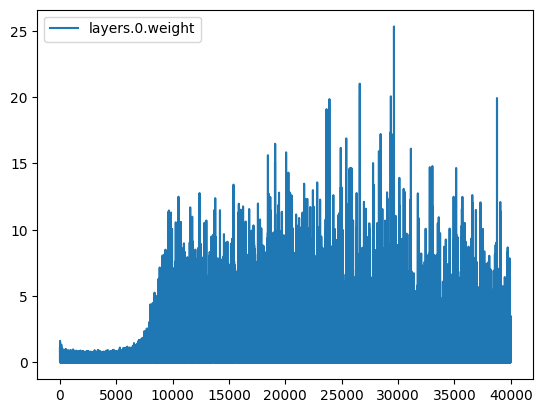

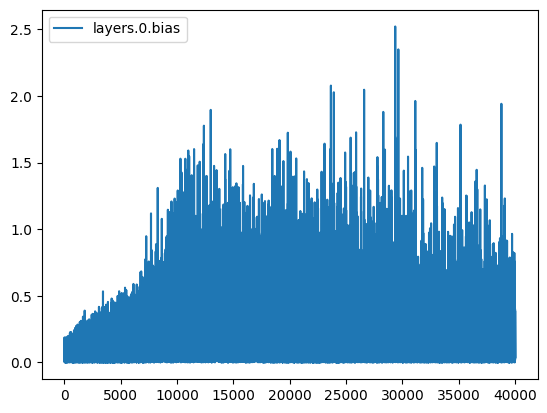

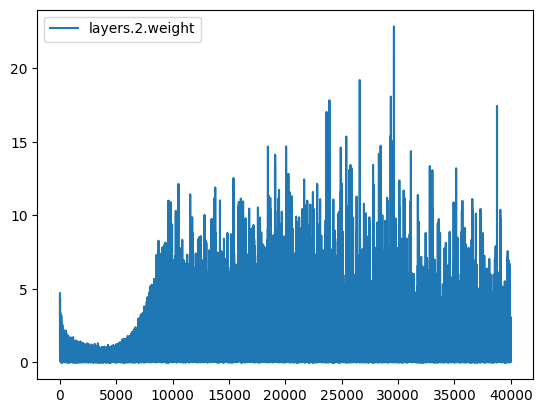

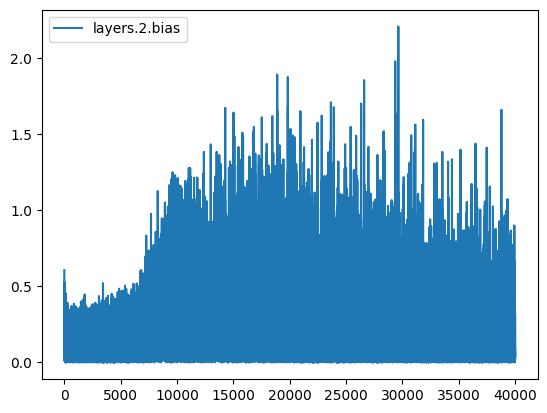

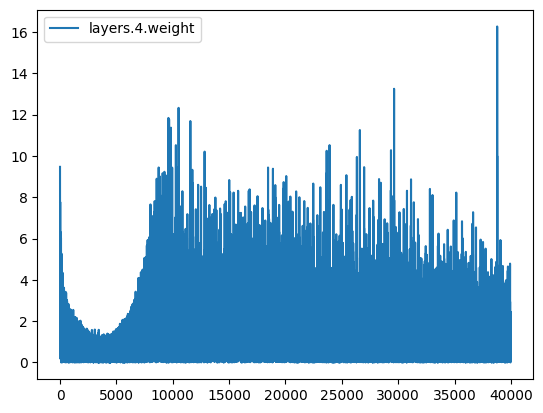

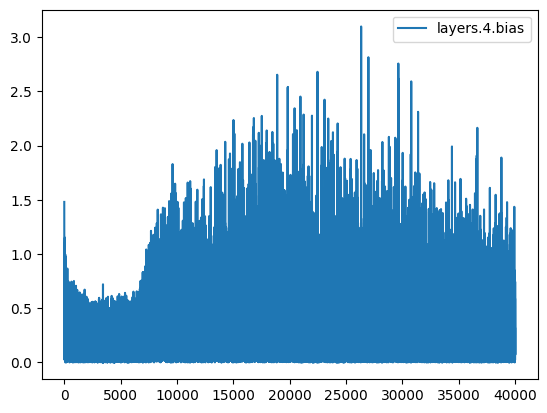

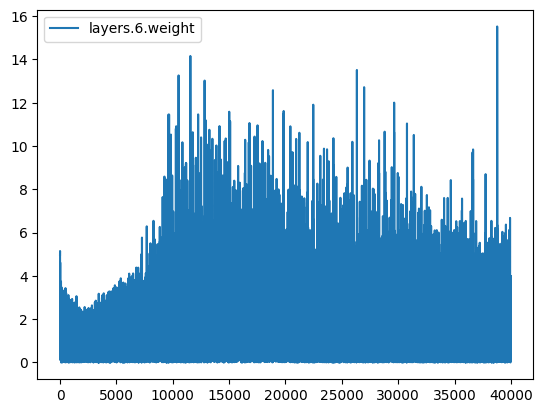

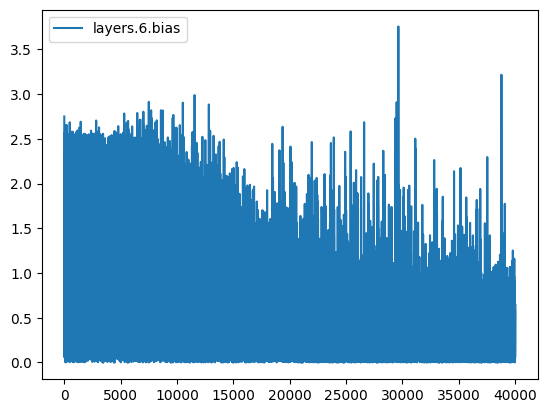

In [12]:
def plot_grad_norms(grad_norm_lists, key):
    num_items =  len(grad_norm_lists[key])
    fig, ax = plt.subplots()
    ax.plot([x for x in range(num_items)], grad_norm_lists[key], label=key)
    ax.legend()

for key in keys:
    plot_grad_norms(grad_norm_lists, key)

In [13]:
grad_series = {}
for key in grad_norm_lists.keys():
    grad_series[key] = pd.Series(grad_norm_lists[key])

for key in grad_series.keys():
    print("parameter: ", key)
    print(grad_series[key].describe())
    print()

parameter:  layers.0.weight
count    40000.000000
mean         1.190809
std          1.696824
min          0.000000
25%          0.217358
50%          0.550139
75%          1.445862
max         25.317007
dtype: float64

parameter:  layers.0.bias
count    40000.000000
mean         0.210170
std          0.225170
min          0.000002
25%          0.051664
50%          0.133580
75%          0.294670
max          2.522470
dtype: float64

parameter:  layers.2.weight
count    40000.000000
mean         1.316226
std          1.494740
min          0.000028
25%          0.412949
50%          0.844776
75%          1.651428
max         22.850508
dtype: float64

parameter:  layers.2.bias
count    40000.000000
mean         0.237182
std          0.229028
min          0.000004
25%          0.070862
50%          0.165724
75%          0.329593
max          2.210022
dtype: float64

parameter:  layers.4.weight
count    40000.000000
mean         1.490269
std          1.308270
min          0.000036
25%     

In [14]:
# Pretraining:
precond_epochs = 500
precond_prime = TinyModel()

precond_lr = 5e-3
precond_optimizer = torch.optim.SGD(precond_model.parameters(), lr=precond_lr)

precond_losses = []
precond_training_losses = []

pre_train_gen = Generator().set_state(base_gen.get_state())
pre_train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, generator=pre_train_gen)

pre_test_gen = Generator().set_state(base_gen.get_state())
pre_test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, generator=pre_test_gen)

Epoch: 1


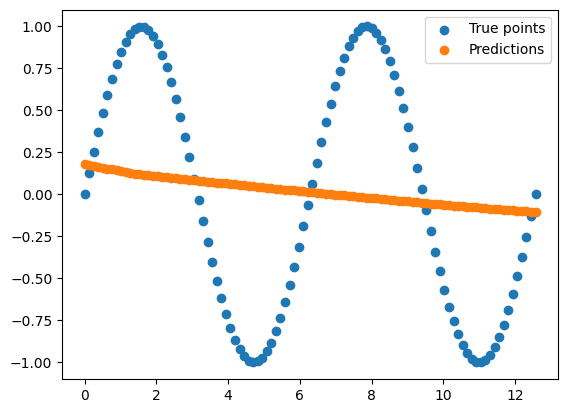

Avg loss: 0.459418 

Epoch: 2


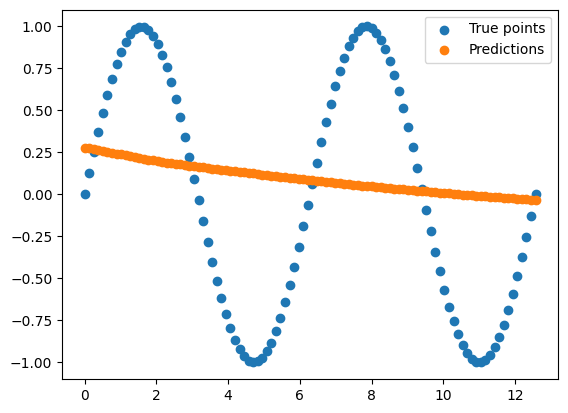

Avg loss: 0.464728 

Epoch: 3


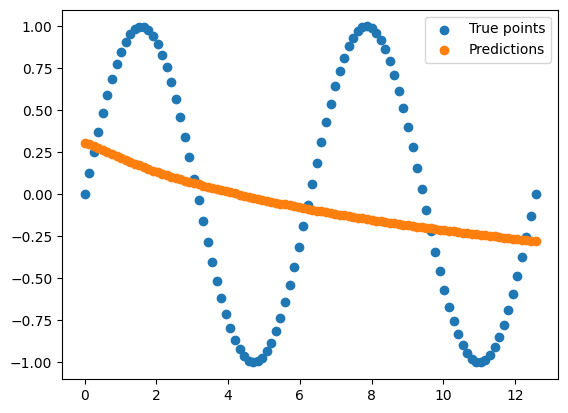

Avg loss: 0.435365 

Epoch: 4


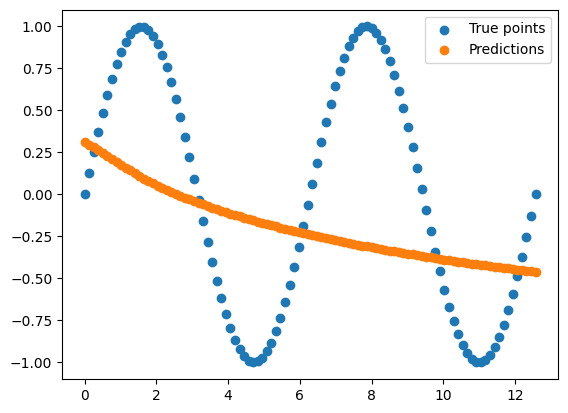

Avg loss: 0.458291 

Epoch: 5


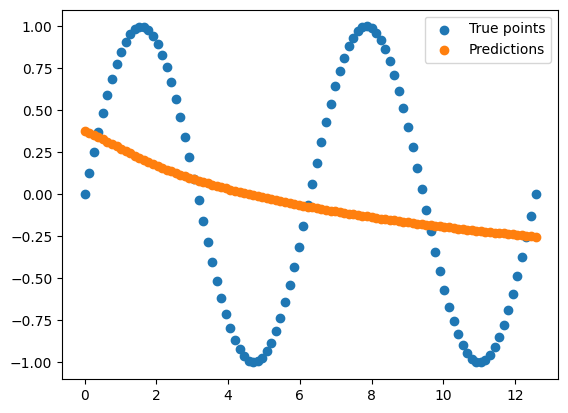

Avg loss: 0.429712 

Epoch: 6


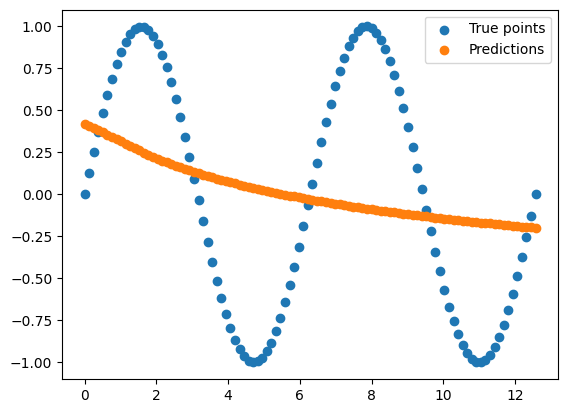

Avg loss: 0.429275 

Epoch: 7


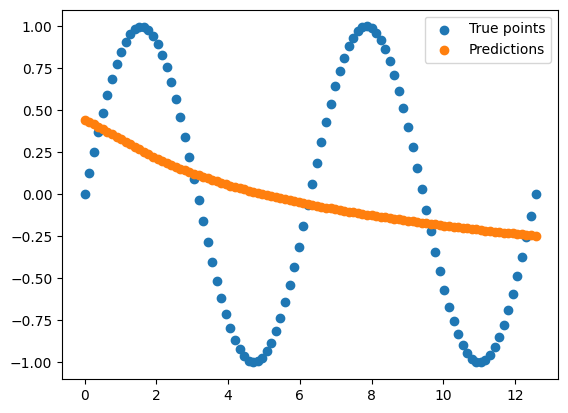

Avg loss: 0.424968 

Epoch: 8


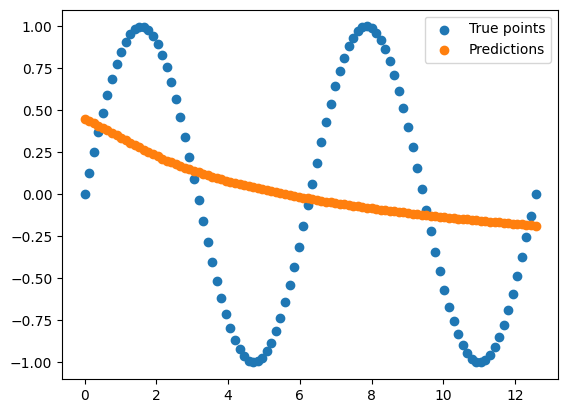

Avg loss: 0.428299 

Epoch: 9


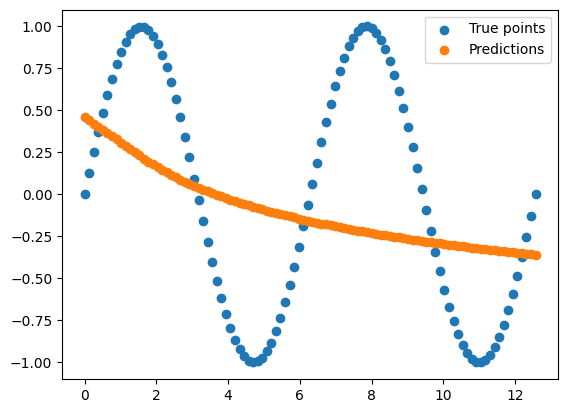

Avg loss: 0.428381 

Epoch: 10


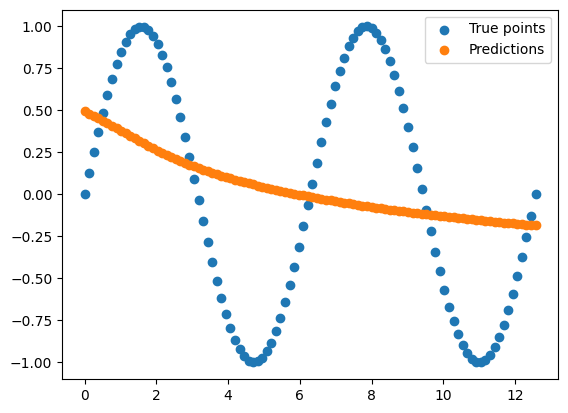

Avg loss: 0.426374 

Epoch: 11


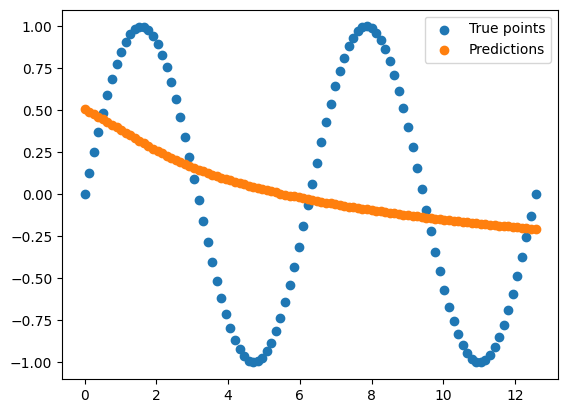

Avg loss: 0.423701 

Epoch: 12


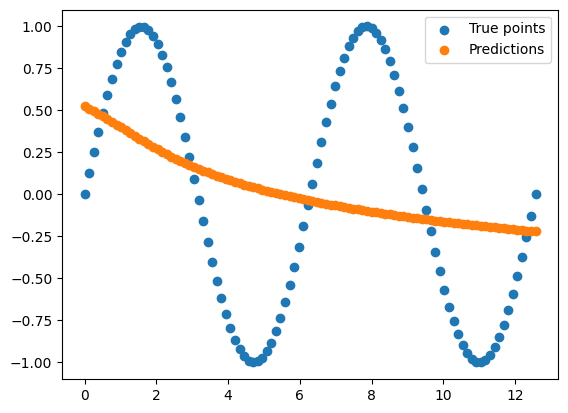

Avg loss: 0.421828 

Epoch: 13


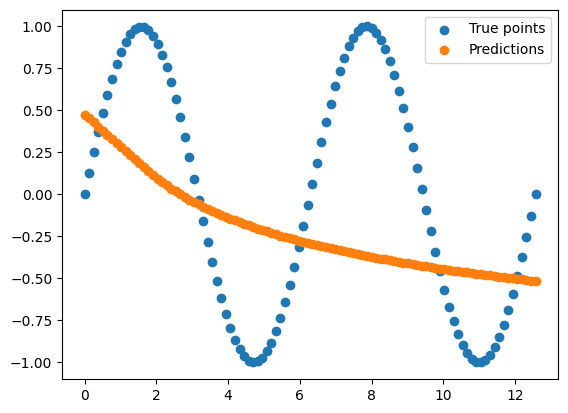

Avg loss: 0.459003 

Epoch: 14


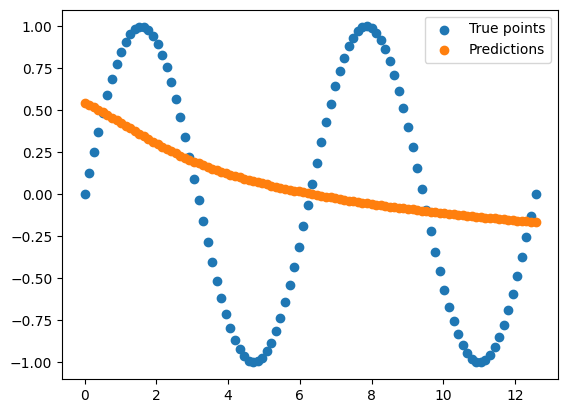

Avg loss: 0.426662 

Epoch: 15


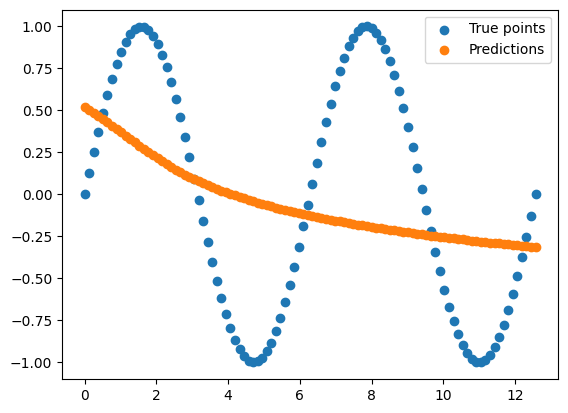

Avg loss: 0.420373 

Epoch: 160


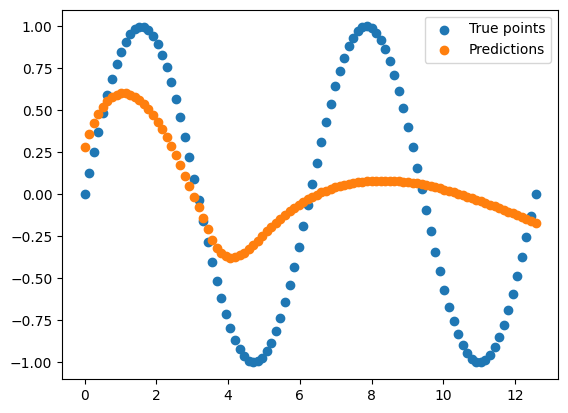

Avg loss: 0.299270 

Epoch: 320


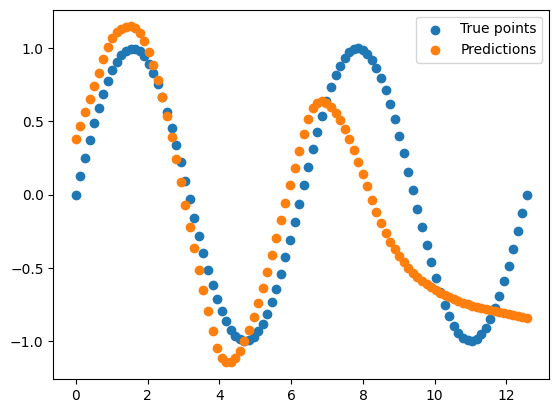

Avg loss: 0.168381 

Epoch: 480


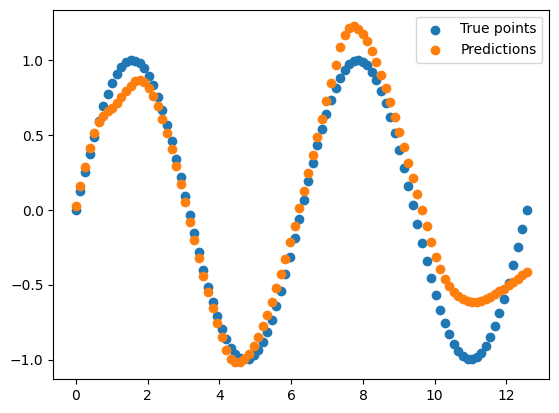

Avg loss: 0.030032 

Epoch: 640


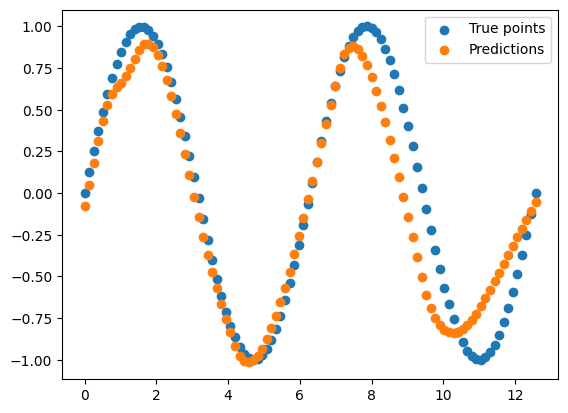

Avg loss: 0.053464 

Epoch: 800


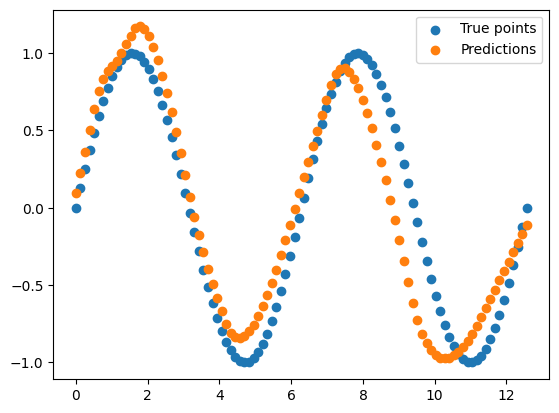

Avg loss: 0.069027 



In [15]:
for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_model, precond_prime, pre_train_dataloader, nbd_loss, precond_optimizer))

training_optimizer = torch.optim.SGD(precond_model.parameters(), lr=learning_rate)
prec_train_losses = []
prec_grads_per_epoch = []

for t in range(epochs):
    
    avg_loss, grads = train_loop_grad_capture(pre_train_dataloader, precond_model, loss_function, training_optimizer)
    prec_train_losses.append(avg_loss)
    prec_grads_per_epoch.append(grads)
    
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(pre_test_dataloader, precond_model, loss_function)

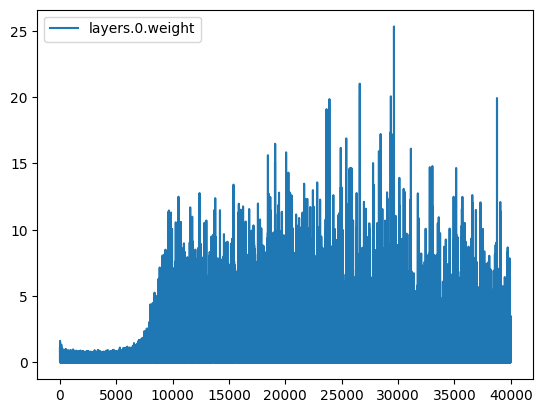

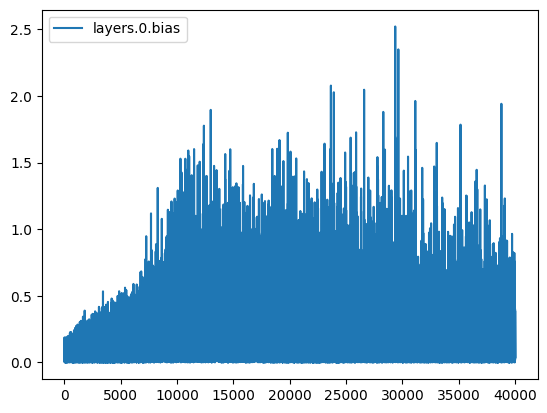

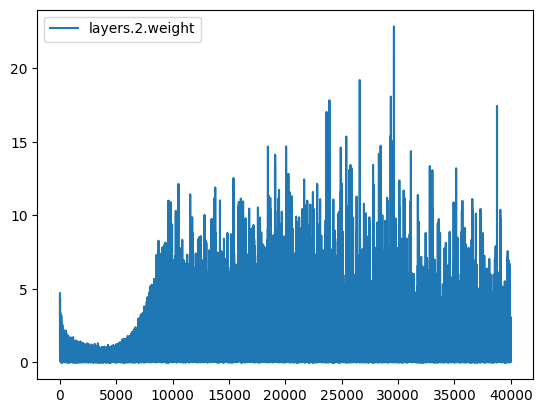

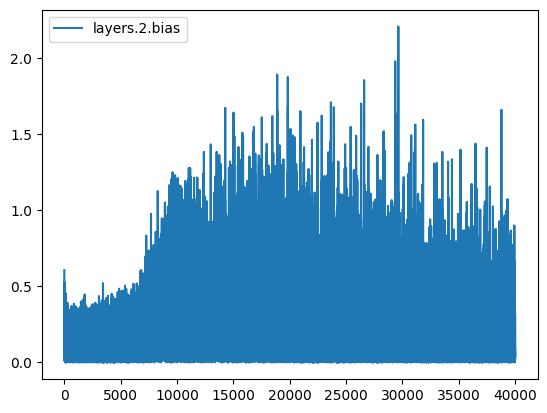

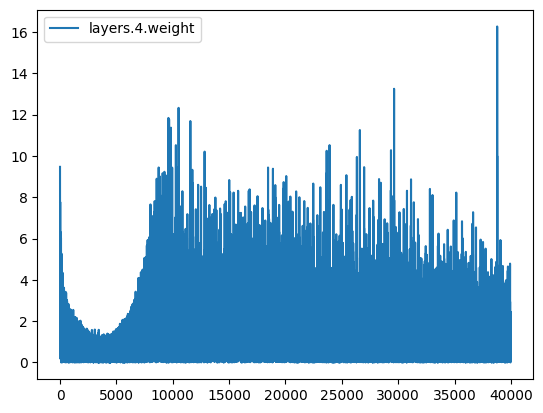

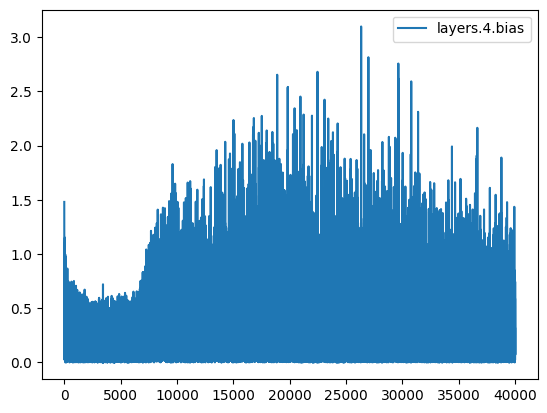

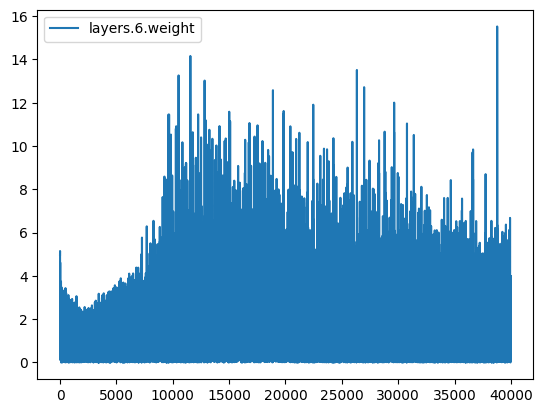

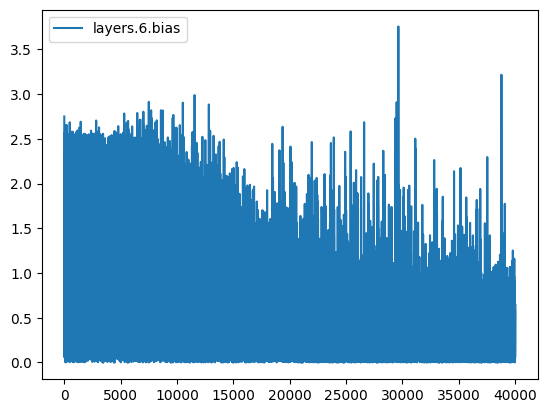

In [16]:
p_grad_lists = make_grad_lists(grads_per_epoch)
p_grad_norm_lists = normed_grad_lists(grad_lists)

for key in keys:
    plot_grad_norms(p_grad_norm_lists, key)